In [1]:
!git clone https://github.com/juanserrano90/codelatam.git

Cloning into 'codelatam'...
remote: Enumerating objects: 75753, done.
remote: Counting objects: 100% (3936/3936), done.
remote: Compressing objects: 100% (3927/3927), done.
remote: Total 75753 (delta 12), reused 3931 (delta 9), pack-reused 71817 (from 2)
Receiving objects: 100% (75753/75753), 693.33 MiB | 17.96 MiB/s, done.
Resolving deltas: 100% (1272/1272), done.
Updating files: 100% (90961/90961), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import glob
import numpy as np
import pandas as pd
import copy
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle
from pathlib import Path
from collections import defaultdict
import random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
from torchvision.io import read_image, ImageReadMode
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
# Global definitions ---------------
data_dir = "/content/codelatam/Data"
working_dir = "/content/drive/MyDrive/Doctorado/Codelatam/Files_codelatam"
num_classes = 3
inv_dict_mapping_classes = {0:'Ia-norm', 1:'Ia-pec', 2:'Others'}
dataset_folder = 'Dataset_augmented_images'

def subtype_to_class_mapping(a):
  subtype_to_class = {0:0, 1:1, 2:1, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:2, 10:2, 11:2, 12:2, 13:2, 14:2, 15:2, 16:2}
  return subtype_to_class[a]

def id_to_subtype_mapping(a):
  id_to_subtype = {0: 'Ia-norm', 1: 'Ia-91T', 3: 'Ia-csm', 2: 'Ia-91bg', 6: 'Ib-norm', 4: 'Iax', 5: 'Ia-pec', 10: 'Ic-norm',
                   13: 'IIP', 14: 'IIL', 8: 'IIb', 16: 'II-pec', 11: 'Ic-broad', 12: 'Ic-pec', 15: 'IIn', 7: 'Ibn', 9: 'Ib-pec'}
  return id_to_subtype(a)

dataset_versions = [
    'augmented_images_v2.0',
    'augmented_images_v2.0_20x20',
    'augmented_images_v2.0_20x20_n',
    'augmented_images_v2.0_224x112',
    'augmented_images_v2.0_224x112_n',
    'augmented_images_v2.0_224x224',
    'augmented_images_v2.0_224x224_n',
    'augmented_images_v2.0_224x56',
    'augmented_images_v2.0_224x56_n',
    'augmented_images_v2.0_50x50',
    'augmented_images_v2.0_50x50_n',
    ]

In [5]:
def load_split(n):
  # with open(f"{data_dir}/Splits/saved_train_val_test_split_{n}.pkl", 'rb') as f:
  with open(f"{data_dir}/Splits/tvt_split{n}.pkl", 'rb') as f:
    splits = pickle.load(f)
  return splits

def extract_data_from_splits(splits, root_dir):
    data = {'train': [], 'val': [], 'test': []}

    for subfolder, split_dict in splits.items():
        for split, image_list in split_dict.items():
            for image_name in image_list:
              if len(root_dir.split('/')[-1].split('_'))>3:   # dfdw datasets have different naming
                if 'COPY' in image_name:
                  image_name = image_name[:-8] + "m_" + "COPY" + ".png"
                else:
                  image_name = image_name[:-4] + "_m" + ".png"
              image_path = os.path.join(root_dir, subfolder, image_name)
              label = subtype_to_class_mapping(int(image_name.split('_')[1]))
              image_id = image_name[:-4]
              data[split].append((image_path, image_id, label))

    return data['train'], data['val'], data['test']

class CustomDataset(Dataset):
    def __init__(self, data, processor):
        """
        data: list of tuples (image_path, id, label)
        """
        self.image_paths = [d[0] for d in data]
        self.ids = [d[1] for d in data]
        self.labels = [d[2] for d in data]
        self.processor = processor
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = read_image(self.image_paths[idx], mode=ImageReadMode.RGB)
        processed = self.processor(images=image, return_tensors="pt")
        pixel_values = processed['pixel_values'].squeeze(0)
        label = torch.tensor(self.labels[idx]).long()
        return {
            'id': self.ids[idx],
            'pixel_values': pixel_values,
            'y_true': label
        }

def load_datasets(splits, dataset_name, processor):
  train_data, val_data, test_data = extract_data_from_splits(splits, os.path.join(data_dir, dataset_folder, dataset_name))

  train_dataset = CustomDataset(train_data, processor)
  val_dataset = CustomDataset(val_data, processor)
  test_dataset = CustomDataset(test_data, processor)

  print(f'Loading {dataset_name}...')

  return train_dataset, val_dataset, test_dataset

def show_example_image(dataset, n):
  image_data = dataset[n]
  # Denormalize the image using processor's mean and std
  # pixel_values are (C, H, W)
  mean = torch.tensor(processor.image_mean).view(3, 1, 1)
  std = torch.tensor(processor.image_std).view(3, 1, 1)
  denormalized_image = (image_data['pixel_values'] * std) + mean
  # Convert to numpy array, scale to 0-255, and change to uint8
  image_np = (denormalized_image.permute(1, 2, 0).numpy() * 255).astype('uint8')
  img = Image.fromarray(image_np)
  display(img)

def show_model_architecture(model):
  !pip install torchinfo
  from torchinfo import summary
  summary(model)

In [6]:
# # This is to check that the new datasets have the same images as the original
# folder_base_1 = "/content/codelatam/Data/Dataset_augmented_images/v2_old"
# folder_base_2 = "/content/drive/MyDrive/Doctorado/Codelatam/Files_codelatam/Dataset_augmented_images/augmented_images_v2.0_224x112"
# # folder_base_2 = "/content/codelatam/Data/Dataset_augmented_images/augmented_images_v2.0"

# # 11hs_8_1_24.83_4931.png

# for i in range(3): # Iterate through subfolders 0, 1, 2
#   print(f"--- Comparing subfolder {i} ---")

#   # Get image files from the first folder
#   current_folder_1 = os.path.join(folder_base_1, str(i))
#   if os.path.exists(current_folder_1):
#     image_files_1 = set([f for f in os.listdir(current_folder_1) if os.path.isfile(os.path.join(current_folder_1, f)) and f.lower().endswith(('.png'))])
#   else:
#     image_files_1 = set()
#     print(f"Warning: Folder {current_folder_1} not found.")

#   # Get image files from the second folder
#   current_folder_2 = os.path.join(folder_base_2, str(i))
#   if os.path.exists(current_folder_2):
#     image_files_2 = set([f.replace("_m", "") for f in os.listdir(current_folder_2) if os.path.isfile(os.path.join(current_folder_2, f)) and f.lower().endswith(('.png'))])
#   else:
#     image_files_2 = set()
#     print(f"Warning: Folder {current_folder_2} not found.")

#   # Find images in folder 1 but not in folder 2
#   in_1_not_2 = image_files_1 - image_files_2

#   # Find images in folder 2 but not in folder 1
#   in_2_not_1 = image_files_2 - image_files_1

#   if in_1_not_2:
#     print(f"Images in {current_folder_1} but not in {current_folder_2}:")
#     for img in sorted(list(in_1_not_2)):
#       print(f"  - {img}")
#   else:
#     print(f"No unique images found in {current_folder_1} compared to {current_folder_2}.")

#   if in_2_not_1:
#     print(f"Images in {current_folder_2} but not in {current_folder_1}:")
#     for img in sorted(list(in_2_not_1)):
#       print(f"  - {img}")
#   else:
#     print(f"No unique images found in {current_folder_2} compared to {current_folder_1}.")

#   if not in_1_not_2 and not in_2_not_1:
#     print(f"All images are identical in both folders for subfolder {i}.")
#   print("") # Add a blank line for readability

In [7]:
def get_sn_info(filename):
    try:
        parts = filename.split('_')
        sn_name = parts[0]
        subtype = int(parts[1])
        return sn_name, subtype
    except:
        return None, None

def verify_split_stats(split_results):
    print(
        f"{'Class':<6} | {'Set':<6} | {'Images':<6} | {'%':<5} | "
        f"{'Unique SNs':<10} | {'Subtypes':<8} | {'COPY imgs'}"
    )
    print("-" * 90)

    for cls in split_results:
        total_imgs = sum(len(split_results[cls][s]) for s in split_results[cls])

        for s in ['train', 'val', 'test']:
            imgs = split_results[cls][s]
            n_imgs = len(imgs)
            pct = (n_imgs / total_imgs * 100) if total_imgs > 0 else 0

            sns = [get_sn_info(i)[0] for i in imgs]
            subtypes = [get_sn_info(i)[1] for i in imgs]

            unique_sns = set(sns)
            unique_subtypes = set(st for st in subtypes if st is not None)

            n_copy = sum("COPY" in img for img in imgs)

            print(
                f"{cls:<6} | {s:<6} | {n_imgs:<6} | {pct:4.1f}% | "
                f"{len(unique_sns):<10} | {len(unique_subtypes):<8} | {n_copy}"
            )
        print("-" * 90)

def print_split_overlap(split_a, split_b, title=None):

    if title is not None:
      print("=" * len(title))
      print(title)
      print("=" * len(title))

    for s in ['train', 'val', 'test']:
        print(f"\nSubset: {s.upper()}")
        print("-" * 50)

        for cls in ['0', '1', '2']:
            a = split_a[cls][s]
            b = split_b[cls][s]

            overlap = len([x for x in a if x in b])
            total = min(len(a), len(b))
            pct = 100 * overlap / total if total > 0 else 0.0

            print(
                f"Class {cls}: "
                f"{overlap:4d} shared "
                f"({pct:5.1f}%) "
                f"[A={len(a)}, B={len(b)}]"
            )

split1 = load_split(1)
split2 = load_split(2)
split3 = load_split(3)
split4 = load_split(4)

In [8]:
verify_split_stats(split1)
verify_split_stats(split2)
verify_split_stats(split3)
verify_split_stats(split4)

Class  | Set    | Images | %     | Unique SNs | Subtypes | COPY imgs
------------------------------------------------------------------------------------------
0      | train  | 1901   | 79.6% | 256        | 1        | 0
0      | val    | 243    | 10.2% | 32         | 1        | 0
0      | test   | 243    | 10.2% | 31         | 1        | 0
------------------------------------------------------------------------------------------
1      | train  | 1907   | 91.0% | 71         | 5        | 1180
1      | val    | 95     |  4.5% | 11         | 2        | 14
1      | test   | 93     |  4.4% | 13         | 3        | 0
------------------------------------------------------------------------------------------
2      | train  | 1907   | 86.7% | 77         | 11       | 868
2      | val    | 146    |  6.6% | 13         | 5        | 0
2      | test   | 146    |  6.6% | 12         | 5        | 0
------------------------------------------------------------------------------------------
Class  | Set

In [9]:
print_split_overlap(split1, split2, title="Split 1 vs Split 2")
print_split_overlap(split1, split3, title="Split 1 vs Split 3")
print_split_overlap(split1, split4, title="Split 1 vs Split 4")
print_split_overlap(split2, split3, title="Split 2 vs Split 3")
print_split_overlap(split2, split4, title="Split 2 vs Split 4")
print_split_overlap(split3, split4, title="Split 3 vs Split 4")

Split 1 vs Split 2

Subset: TRAIN
--------------------------------------------------
Class 0: 1668 shared ( 87.7%) [A=1901, B=1901]
Class 1: 1842 shared ( 96.6%) [A=1907, B=1907]
Class 2: 1779 shared ( 93.3%) [A=1907, B=1907]

Subset: VAL
--------------------------------------------------
Class 0:   10 shared (  4.1%) [A=243, B=243]
Class 1:   30 shared ( 31.6%) [A=95, B=95]
Class 2:   18 shared ( 12.3%) [A=146, B=146]

Subset: TEST
--------------------------------------------------
Class 0:  243 shared (100.0%) [A=243, B=243]
Class 1:   93 shared (100.0%) [A=93, B=93]
Class 2:  146 shared (100.0%) [A=146, B=146]
Split 1 vs Split 3

Subset: TRAIN
--------------------------------------------------
Class 0: 1702 shared ( 89.5%) [A=1901, B=1901]
Class 1: 1822 shared ( 95.5%) [A=1907, B=1907]
Class 2: 1796 shared ( 94.2%) [A=1907, B=1907]

Subset: VAL
--------------------------------------------------
Class 0:   44 shared ( 18.1%) [A=243, B=243]
Class 1:   10 shared ( 10.5%) [A=95, B=95]
C

In [10]:
def load_model_and_classifier(pt_model_name, dropout, head_n):

  if 'google' in pt_model_name:
    model = ViTModel.from_pretrained(pt_model_name).to(device)
  elif 'microsoft' in pt_model_name:
    model = Swinv2Model.from_pretrained(pt_model_name).to(device)
  elif 'facebook' in pt_model_name:
    model = DINOv3ViTModel.from_pretrained(pt_model_name).to(device)

  if head_n == 3:
    classifier = nn.Sequential(
      nn.Linear(model.config.hidden_size, 512),
      nn.ReLU(),
      nn.Dropout(dropout),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Dropout(dropout),
      nn.Linear(256, num_classes)
      ).to(device)

  elif head_n == 2:
    classifier = nn.Sequential(
      nn.Linear(model.config.hidden_size, 256),
      nn.GELU(),
      nn.Dropout(dropout),
      nn.Linear(256, num_classes)).to(device)

  elif head_n == 1:
    classifier = nn.Sequential(
        nn.Linear(model.config.hidden_size, num_classes)).to(device)

  return model, classifier

def train_step(batch_data, model, processor, classifier, optimizer, device):
    model.train()
    classifier.train()
    y_true = batch_data['y_true'].to(device)

    # inputs = processor(images=batch_data['pixel_values'], return_tensors="pt", do_convert_rgb=False).to(device)
    # outputs = model(**inputs)
    inputs = batch_data['pixel_values'].to(device)
    outputs = model(inputs)
    # pooled_output = outputs.last_hidden_state[:, 0, :]             # alternatively
    pooled_output = outputs.pooler_output

    logits = classifier(pooled_output)
    loss = F.cross_entropy(logits, y_true)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred = torch.argmax(logits, dim=-1)
    return loss.item(), y_pred, y_true


def validate_step(batch_data, model, processor, classifier, device):
    model.eval()
    classifier.eval()
    with torch.no_grad():
        y_true = batch_data['y_true'].to(device)

        inputs = batch_data['pixel_values'].to(device)
        outputs = model(inputs)
        pooled_output = outputs.pooler_output

        logits = classifier(pooled_output)
        loss = F.cross_entropy(logits, y_true)

        y_pred = torch.argmax(logits, dim=-1)
        return loss.item(), y_pred, y_true


def predict_step(batch_data, model, processor, classifier, device):
    model.eval()
    classifier.eval()
    with torch.no_grad():
        y_true = batch_data['y_true'].to(device)

        inputs = batch_data['pixel_values'].to(device)
        outputs = model(inputs)
        pooled_output = outputs.pooler_output

        logits = classifier(pooled_output)
        y_pred_prob = F.softmax(logits, dim=1)
        y_pred = torch.argmax(logits, dim=-1)

        return {
            'id': batch_data['id'],
            'y_pred': y_pred.cpu(),
            'y_pred_prob': y_pred_prob.cpu(),
            'y_true': y_true.cpu()
        }

def load_processor(pt_model_name):
  if 'google' in pt_model_name:
    processor = ViTImageProcessor.from_pretrained(pt_model_name)
  elif 'microsoft' in pt_model_name:
    processor = AutoImageProcessor.from_pretrained(pt_model_name, use_fast=True)
  elif 'facebook' in pt_model_name:
    from huggingface_hub import notebook_login
    notebook_login()
    processor = AutoImageProcessor.from_pretrained(pt_model_name, use_fast=True)

  return processor

In [11]:
def train_model(
    model,
    classifier,
    processor,
    device,
    hp,
    train_dataloader,
    val_dataloader,
    save_dir=None,
    save_model=False,
    ):

    # ------------------
    # Tracking
    history = {
        "train_loss": [],
        "train_acc": [],
        "train_f1": [],
        "val_loss": [],
        "val_acc": [],
        "val_f1": [],
        "lr": [],
    }

    best_val_loss = float("inf")
    best_f1 = float("-inf")
    best_state = {}
    patience_counter = 0

    if type(hp['freeze']) == bool:
      if hp['freeze']:
        print(f"Freezing all backbone layers...")
        for param in model.parameters():
            param.requires_grad = False
        trainable_params = list(classifier.parameters())
      else:
        trainable_params = list(model.parameters()) + list(classifier.parameters())
    elif type(hp['freeze']) == int:
      # First, freeze the entire backbone
      for param in model.parameters():
          param.requires_grad = False

      if 'google' in pt_model_name:
        encoder_layers = model.encoder.layer
      elif 'facebook' in pt_model_name:
        encoder_layers = model.layer
      elif 'microsoft' in pt_model_name:
        encoder_layers = model.encoder.layers

      total_layers = len(encoder_layers)
      start_idx = max(0, total_layers - hp['freeze'])
      print(f"Unfreezing encoder layers {start_idx} to {total_layers-1}...")

      for i in range(start_idx, total_layers):
          for param in encoder_layers[i].parameters():
              param.requires_grad = True

      # Always Unfreeze the Normalization layer before the head (important for ViT!)
      if 'google' in pt_model_name:
        for param in model.layernorm.parameters():
            param.requires_grad = True
      elif 'microsoft' in pt_model_name:
        for param in model.layernorm.parameters():
            param.requires_grad = True
      elif 'facebook' in pt_model_name:
        for param in model.norm.parameters():
            param.requires_grad = True

      trainable_params = [p for p in model.parameters() if p.requires_grad] + \
                        [p for p in classifier.parameters() if p.requires_grad]

    optimizer = AdamW(trainable_params, lr=hp['lr'], weight_decay=hp['wd'])

    if hp['scheduler'] is not None:
      if hp['scheduler'] == "constant":
        scheduler = get_constant_schedule_with_warmup(
            optimizer,
            num_warmup_steps=4,
            )
        print('Using constant scheduler with warmup..')
      if hp['scheduler'] == "cosine":
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=4,
            num_training_steps=hp['epochs'],
            )
        print('Using cosine scheduler with warmup..')

    if save_dir is not None:
        save_path = os.path.join(working_dir, "Runs", save_dir)
        os.makedirs(save_path, exist_ok=True)

    for epoch in range(hp['epochs']):
        # ------------------
        # Training
        train_losses = []
        y_true, y_pred = [], []

        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{hp['epochs']}"):
            loss, preds, targets = train_step(batch, model, processor, classifier, optimizer, device)
            train_losses.append(loss)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

        train_loss = np.mean(train_losses)
        train_acc = accuracy_score(y_true, y_pred)
        train_f1 = f1_score(y_true, y_pred, average="macro")

        # ------------------
        # Validation
        val_losses = []
        y_true, y_pred = [], []

        for batch in val_dataloader:
          loss, preds, targets = validate_step(batch, model, processor, classifier, device)
          val_losses.append(loss)
          y_true.extend(targets.cpu().numpy())
          y_pred.extend(preds.cpu().numpy())

        val_loss = np.mean(val_losses)
        val_acc = accuracy_score(y_true, y_pred)
        val_f1 = f1_score(y_true, y_pred, average="macro")

        # ------------------
        # Logging
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        print(
            f"Epoch {epoch+1}/{hp['epochs']} | "
            f"Train L/A/F1: {train_loss:.4f} {train_acc:.4f} {train_f1:.4f} | "
            f"Val L/A/F1: {val_loss:.4f} {val_acc:.4f} {val_f1:.4f}"
        )

        # ------------------
        # Early stopping
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0

        else:
            patience_counter += 1

        # -------------------
        # Checkpoint F1
        if val_f1 > best_f1:
          best_f1 = val_f1

          best_state = {
              'model': copy.deepcopy(model.state_dict()),
              'classifier': copy.deepcopy(classifier.state_dict()),
              'optimizer': copy.deepcopy(optimizer.state_dict()),
              'epoch': epoch + 1
          }

        if hp['scheduler'] is not None:
          scheduler.step()
          # log LR
          current_lr = optimizer.param_groups[0]["lr"]
          print(f"Epoch {epoch+1} | LR = {current_lr:.2e}")
        else:
          current_lr = hp['lr']

        history["lr"].append(current_lr)

        if patience_counter >= hp['patience']:
            print(f"Early stopping after {epoch+1} epochs.")
            break

    # ------------------
    # Save -------------
    if save_dir is not None:
      base_name = f"_bs_{hp['batch_size']}_lr_{hp['batch_size']}_wd_{hp['wd']}_dp_{hp['dropout']}_pt_{hp['patience']}_f_{hp['freeze']}_h{hp['head_n']}"
      file_name = "model"+base_name+".pth"
      save_path = os.path.join(f"{working_dir}/Runs/{save_dir}", file_name)
      if save_model:
        torch.save(best_state, save_path)

      with open(f"{working_dir}/Runs/{save_dir}/history"+base_name+".json", "w") as f:
        json.dump(history, f, indent=2)

    # Restore best weights
    model.load_state_dict(best_state['model'])
    classifier.load_state_dict(best_state['classifier'])

    return model, classifier, history, best_state

def evaluate(
    model,
    classifier,
    processor,
    dataloader,
    inv_class_map=None,
    save_dir=None,
    ):

    model.eval()
    classifier.eval()

    y_true = []
    y_pred = []
    y_pred_prob = []

    with torch.no_grad():
        for batch in dataloader:
          output = predict_step(batch, model, processor, classifier, device)
          y_true.append(output['y_true'])
          y_pred.append(output['y_pred'])
          y_pred_prob.append(output['y_pred_prob'])

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    y_pred_prob = torch.cat(y_pred_prob).numpy()

    if inv_class_map is not None:
        y_true = [inv_class_map[i] for i in y_true]
        y_pred = [inv_class_map[i] for i in y_pred]

    # --- Classification report ---
    report_str = classification_report(y_true, y_pred, digits=4)
    print("\n=== Classification Report ===")
    print(report_str)

    # --- Save to disk ---
    if save_dir is not None:
      file_name = f"clfreport_bs_{hp['batch_size']}_lr_{hp['batch_size']}_wd_{hp['wd']}_dp_{hp['dropout']}_pt_{hp['patience']}_f_{hp['freeze']}_h{hp['head_n']}.txt"
      txt_path = os.path.join(f"{working_dir}/Runs/{save_dir}", file_name)
      with open(txt_path, "w") as f:
        f.write(report_str)

    return y_true, y_pred, y_pred_prob

def plot_training_curves(
    history,
    curves=("loss", "acc", "f1"),
    log_loss=False,
    figsize_per_plot=(5, 4),
    save_dir=None,
    dpi=100
):

    valid_curves = {"loss", "acc", "f1"}
    curves = [c for c in curves if c in valid_curves]

    if len(curves) == 0:
        raise ValueError("No valid curves selected. Choose from 'loss', 'acc', 'f1'.")

    n_plots = len(curves)
    fig, axes = plt.subplots(
        1, n_plots,
        figsize=(figsize_per_plot[0] * n_plots, figsize_per_plot[1])
    )

    if n_plots == 1:
        axes = [axes]

    for ax, curve in zip(axes, curves):

        if curve == "loss":
            ax.plot(history["train_loss"], label="Train Loss")
            ax.plot(history["val_loss"], label="Validation Loss")
            ax.set_ylabel("Loss")
            ax.set_title("Loss Curves")
            if log_loss:
                ax.set_yscale("log")

        elif curve == "acc":
            ax.plot(history["train_acc"], label="Train Accuracy")
            ax.plot(history["val_acc"], label="Validation Accuracy")
            ax.set_ylabel("Accuracy")
            ax.set_title("Accuracy Curves")

        elif curve == "f1":
            ax.plot(history["train_f1"], label="Train F1")
            ax.plot(history["val_f1"], label="Validation F1")
            ax.set_ylabel("F1 Score")
            ax.set_title("F1 Score Curves")

        ax.set_xlabel("Epoch")
        ax.legend()
        ax.grid(alpha=0.3)

    plt.tight_layout()
    if save_dir is not None:
      file_name = f"trace_bs_{hp['batch_size']}_lr_{hp['batch_size']}_wd_{hp['wd']}_dp_{hp['dropout']}_pt_{hp['patience']}_f_{hp['freeze']}_h{hp['head_n']}.png"
      save_path = os.path.join(f"{working_dir}/Runs/{save_dir}", file_name)
      plt.savefig(save_path, dpi=dpi, bbox_inches="tight")

    plt.show()

def plot_confusion_matrix(
    y_true,
    y_pred,
    inv_dict_mapping_classes,
    normalize=True,
    figsize=(10, 7),
    save_dir=None,
    dpi=100
):

    cm = confusion_matrix(y_true, y_pred)
    class_names = inv_dict_mapping_classes.values()

    if normalize:
        cm = cm.astype(float)
        row_sums = cm.sum(axis=1, keepdims=True)
        cm = np.divide(cm, row_sums, where=row_sums != 0)

    plt.figure(figsize=figsize)

    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f" if normalize else "d",
        cmap="Blues",
        cbar=False,
        xticklabels=class_names,
        yticklabels=class_names
    )

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    title = "Confusion Matrix (Normalized)" if normalize else "Confusion Matrix"
    plt.title(title)

    plt.tight_layout()

    if save_dir is not None:
      file_name = f"cfmatrix_bs_{hp['batch_size']}_lr_{hp['lr']}_wd_{hp['wd']}_dp_{hp['dropout']}_pt_{hp['patience']}_f_{hp['freeze']}_h{hp['head_n']}.png"
      save_path = os.path.join(f"{working_dir}/Runs/{save_dir}", file_name)
      plt.savefig(save_path, dpi=dpi, bbox_inches="tight")

    plt.show()

In [12]:
import torch.nn as nn
from transformers import ViTImageProcessor, ViTModel
from transformers import AutoImageProcessor, Swinv2Model
from transformers import DINOv3ViTModel
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from transformers import get_constant_schedule_with_warmup, get_cosine_schedule_with_warmup
from huggingface_hub import notebook_login

In [13]:
# Inspect processor
# print(processor)

# Show model architecture --
# show_model_architecture(model)

# Show an image --------------
# show_example_image(train_dataset, 0)

In [14]:
# dataset_name = 'augmented_images_v2.0'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pt_model_names = {'ViT32': 'google/vit-base-patch32-224-in21k',
                  'ViT16': 'google/vit-base-patch16-224-in21k',
                  'Swinv2': 'microsoft/swinv2-tiny-patch4-window16-256',
                  'DINOv3': 'facebook/dinov3-vits16-pretrain-lvd1689m'}

def run(dataset_name, hp, pt_model_name, n_split, save_dir):
  # Load datasets ----
  splits = load_split(n_split)
  processor = load_processor(pt_model_name)
  train_dataset, val_dataset, test_dataset = load_datasets(splits, dataset_name, processor)

  # This is for reproducibility ----------
  seed = 10
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  generator = torch.Generator()
  generator.manual_seed(seed)

  # ---------------------------------------
  # Load model and classifier
  model, classifier = load_model_and_classifier(
      pt_model_name,
      hp['dropout'],
      head_n=hp['head_n']
      )
  # ---------------------------------------
  # Load datasets
  train_dataloader = DataLoader(train_dataset,
                                batch_size=hp['batch_size'],
                                shuffle=True,
                                generator=generator,
                                num_workers=2,
                                )

  val_dataloader = DataLoader(val_dataset, batch_size=hp['batch_size'], num_workers=2)
  test_dataloader = DataLoader(test_dataset, batch_size=hp['batch_size'])

  model, classifier, history, best_model_state = train_model(model,
                                                            classifier,
                                                            processor,
                                                            device,
                                                            hp,
                                                            train_dataloader,
                                                            val_dataloader,
                                                            save_dir=save_dir,
                                                            save_model=False,
                                                            )

  y_true, y_pred, y_pred_prob = evaluate(
    model,
    classifier,
    processor,
    val_dataloader,
    inv_dict_mapping_classes,
    save_dir=save_dir,
    )

  plot_training_curves(
      history,
      curves=(["loss","acc","f1"]),
      log_loss=False,
      figsize_per_plot=(5, 4),
      save_dir=save_dir,
  )

  plot_confusion_matrix(
      y_true, y_pred,
      inv_dict_mapping_classes,
      figsize=(6,6),
      save_dir=save_dir,
      )

Loading augmented_images_v2.0...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 1/200 | Train L/A/F1: 1.1097 0.3312 0.2026 | Val L/A/F1: 1.1255 0.3017 0.1545
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 2/200 | Train L/A/F1: 1.0791 0.4639 0.4464 | Val L/A/F1: 1.0661 0.6136 0.4898
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 3/200 | Train L/A/F1: 0.8954 0.7438 0.7345 | Val L/A/F1: 0.7975 0.7231 0.6487
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 11.01it/s]


Epoch 4/200 | Train L/A/F1: 0.4885 0.8716 0.8690 | Val L/A/F1: 0.4346 0.8636 0.8270
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 5/200 | Train L/A/F1: 0.2399 0.9311 0.9308 | Val L/A/F1: 0.3701 0.8574 0.8101
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 6/200 | Train L/A/F1: 0.1261 0.9659 0.9658 | Val L/A/F1: 0.4229 0.8781 0.8472
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.99it/s]


Epoch 7/200 | Train L/A/F1: 0.0678 0.9822 0.9821 | Val L/A/F1: 0.5189 0.8512 0.8341
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 8/200 | Train L/A/F1: 0.0399 0.9916 0.9916 | Val L/A/F1: 0.4664 0.8760 0.8296
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 9/200 | Train L/A/F1: 0.0403 0.9895 0.9895 | Val L/A/F1: 0.5121 0.8781 0.8456
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 10/200 | Train L/A/F1: 0.0219 0.9956 0.9956 | Val L/A/F1: 0.4741 0.8740 0.8497
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 11/200 | Train L/A/F1: 0.0167 0.9965 0.9965 | Val L/A/F1: 0.6474 0.8347 0.8189
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 12/200 | Train L/A/F1: 0.0131 0.9983 0.9982 | Val L/A/F1: 0.5493 0.8719 0.8456
Epoch 12 | LR = 1.00e-05
Early stopping after 12 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.9102    0.9177    0.9139       243
      Ia-pec     0.6990    0.7579    0.7273        95
      Others     0.9412    0.8767    0.9078       146

    accuracy                         0.8740       484
   macro avg     0.8501    0.8508    0.8497       484
weighted avg     0.8781    0.8740    0.8754       484



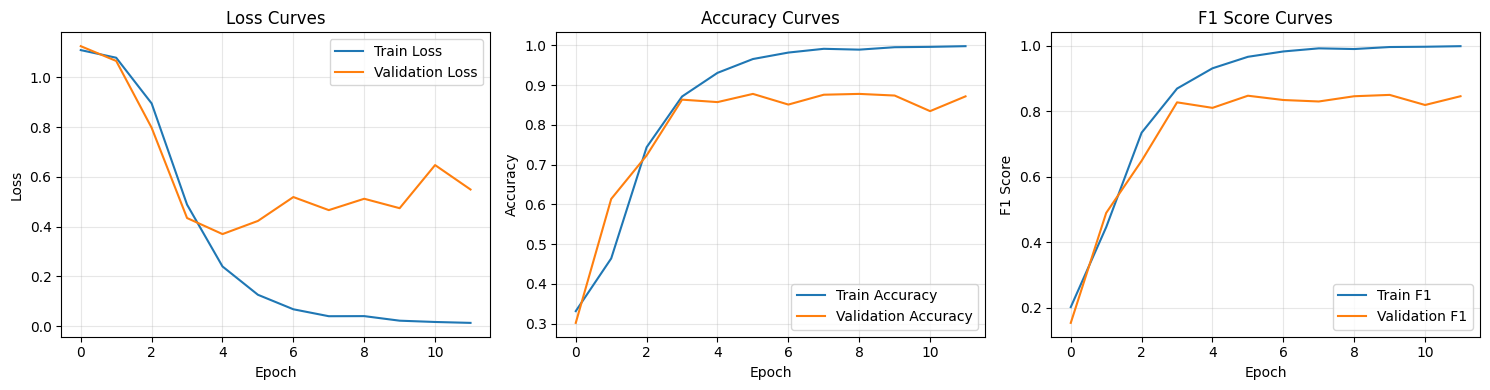

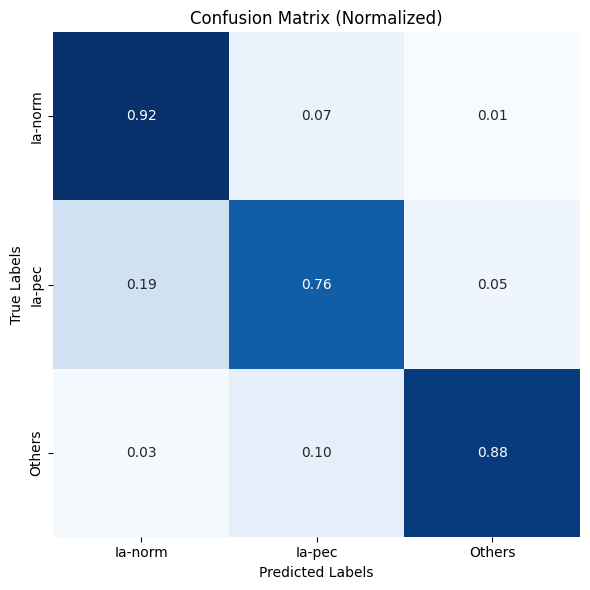

Loading augmented_images_v2.0...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 1/200 | Train L/A/F1: 1.1097 0.3283 0.1994 | Val L/A/F1: 1.1258 0.3017 0.1545
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 2/200 | Train L/A/F1: 1.0786 0.4579 0.4397 | Val L/A/F1: 1.0542 0.6281 0.5229
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 3/200 | Train L/A/F1: 0.8974 0.7360 0.7253 | Val L/A/F1: 0.7719 0.7748 0.6853
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.99it/s]


Epoch 4/200 | Train L/A/F1: 0.4888 0.8756 0.8736 | Val L/A/F1: 0.4083 0.8616 0.8156
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 5/200 | Train L/A/F1: 0.2369 0.9325 0.9322 | Val L/A/F1: 0.3474 0.8595 0.8000
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.99it/s]


Epoch 6/200 | Train L/A/F1: 0.1241 0.9675 0.9674 | Val L/A/F1: 0.3210 0.8988 0.8670
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 7/200 | Train L/A/F1: 0.0776 0.9783 0.9783 | Val L/A/F1: 0.3534 0.8636 0.8293
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 8/200 | Train L/A/F1: 0.0400 0.9900 0.9900 | Val L/A/F1: 0.5270 0.8616 0.8265
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 9/200 | Train L/A/F1: 0.0258 0.9951 0.9951 | Val L/A/F1: 0.5747 0.8616 0.8264
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 10/200 | Train L/A/F1: 0.0210 0.9955 0.9955 | Val L/A/F1: 0.3610 0.8946 0.8712
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 11/200 | Train L/A/F1: 0.0198 0.9951 0.9951 | Val L/A/F1: 0.4128 0.8843 0.8413
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 12/200 | Train L/A/F1: 0.0252 0.9921 0.9921 | Val L/A/F1: 0.4925 0.8740 0.8406
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 13/200 | Train L/A/F1: 0.0213 0.9937 0.9937 | Val L/A/F1: 0.3366 0.9008 0.8832
Epoch 13 | LR = 1.00e-05
Early stopping after 13 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.9184    0.9259    0.9221       243
      Ia-pec     0.7404    0.8105    0.7739        95
      Others     0.9926    0.9178    0.9537       146

    accuracy                         0.9008       484
   macro avg     0.8838    0.8848    0.8832       484
weighted avg     0.9058    0.9008    0.9026       484



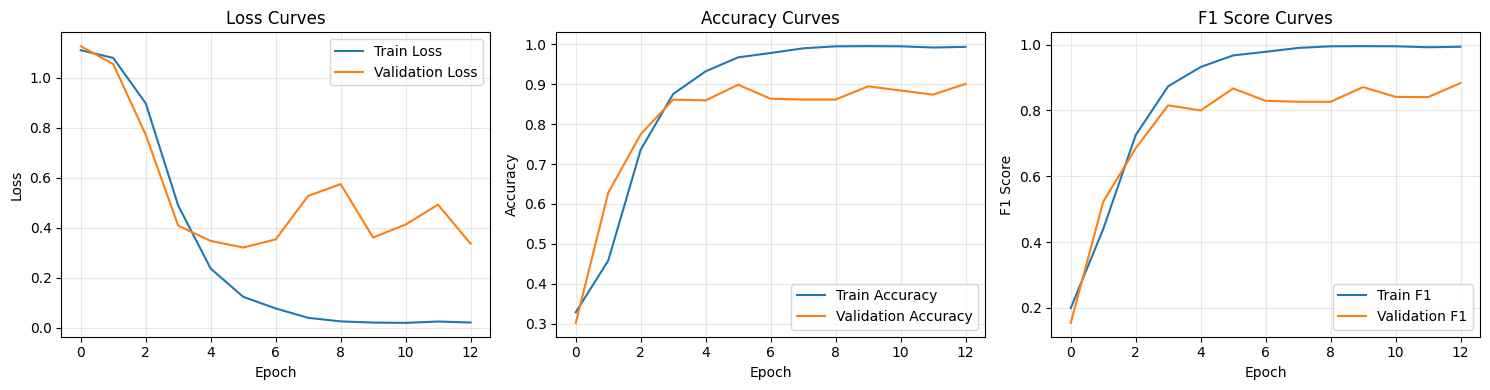

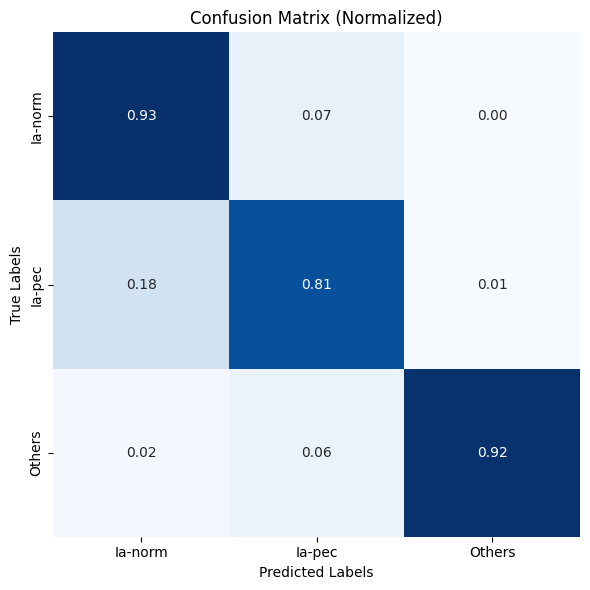

Loading augmented_images_v2.0...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 1/200 | Train L/A/F1: 1.1097 0.3288 0.1990 | Val L/A/F1: 1.1251 0.3017 0.1545
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 2/200 | Train L/A/F1: 1.0792 0.4658 0.4508 | Val L/A/F1: 1.0631 0.5661 0.4405
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 3/200 | Train L/A/F1: 0.8927 0.7477 0.7386 | Val L/A/F1: 0.8041 0.7128 0.6022
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 4/200 | Train L/A/F1: 0.4792 0.8789 0.8769 | Val L/A/F1: 0.4600 0.8430 0.7848
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 5/200 | Train L/A/F1: 0.2332 0.9321 0.9318 | Val L/A/F1: 0.3862 0.8574 0.8127
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 6/200 | Train L/A/F1: 0.1224 0.9692 0.9692 | Val L/A/F1: 0.3807 0.8802 0.8402
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 7/200 | Train L/A/F1: 0.0733 0.9811 0.9811 | Val L/A/F1: 0.3760 0.8988 0.8678
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 8/200 | Train L/A/F1: 0.0418 0.9916 0.9916 | Val L/A/F1: 0.4318 0.8781 0.8375
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 11.00it/s]


Epoch 9/200 | Train L/A/F1: 0.0352 0.9920 0.9919 | Val L/A/F1: 0.3518 0.8926 0.8670
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 10/200 | Train L/A/F1: 0.0278 0.9934 0.9934 | Val L/A/F1: 0.4194 0.8946 0.8645
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 11/200 | Train L/A/F1: 0.0265 0.9932 0.9932 | Val L/A/F1: 0.3944 0.8864 0.8620
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 12/200 | Train L/A/F1: 0.0141 0.9974 0.9974 | Val L/A/F1: 0.4119 0.8822 0.8605
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 13/200 | Train L/A/F1: 0.0176 0.9962 0.9961 | Val L/A/F1: 0.7017 0.8450 0.8177
Epoch 13 | LR = 1.00e-05


Epoch 14/200: 100%|██████████| 179/179 [00:16<00:00, 10.99it/s]


Epoch 14/200 | Train L/A/F1: 0.0177 0.9955 0.9955 | Val L/A/F1: 0.7963 0.8285 0.8005
Epoch 14 | LR = 1.00e-05


Epoch 15/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 15/200 | Train L/A/F1: 0.0094 0.9983 0.9983 | Val L/A/F1: 0.5447 0.8822 0.8435
Epoch 15 | LR = 1.00e-05


Epoch 16/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 16/200 | Train L/A/F1: 0.0068 0.9991 0.9991 | Val L/A/F1: 0.4845 0.8905 0.8616
Epoch 16 | LR = 1.00e-05
Early stopping after 16 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.9066    0.9588    0.9320       243
      Ia-pec     0.8841    0.6421    0.7439        95
      Others     0.8924    0.9658    0.9276       146

    accuracy                         0.8988       484
   macro avg     0.8944    0.8556    0.8678       484
weighted avg     0.8979    0.8988    0.8938       484



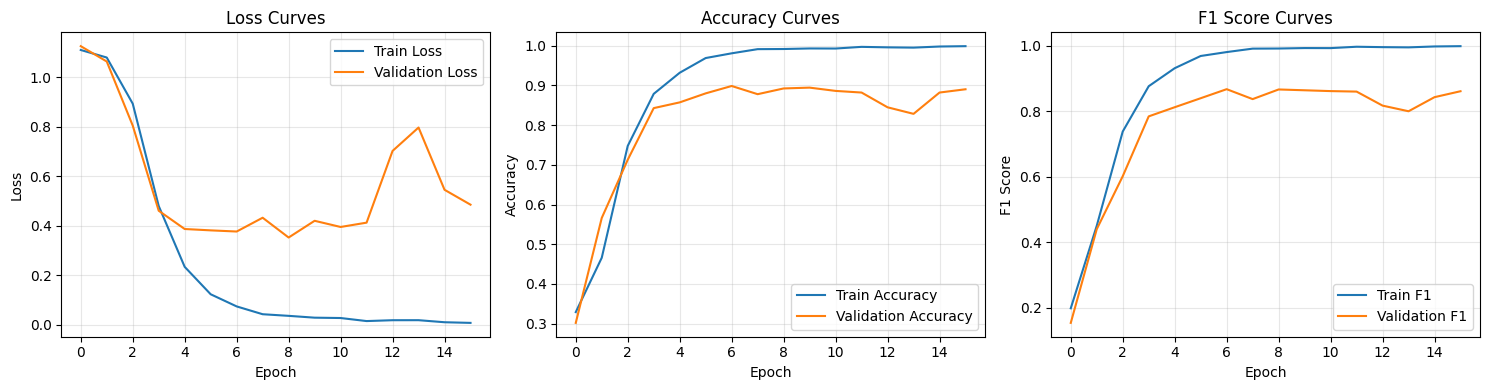

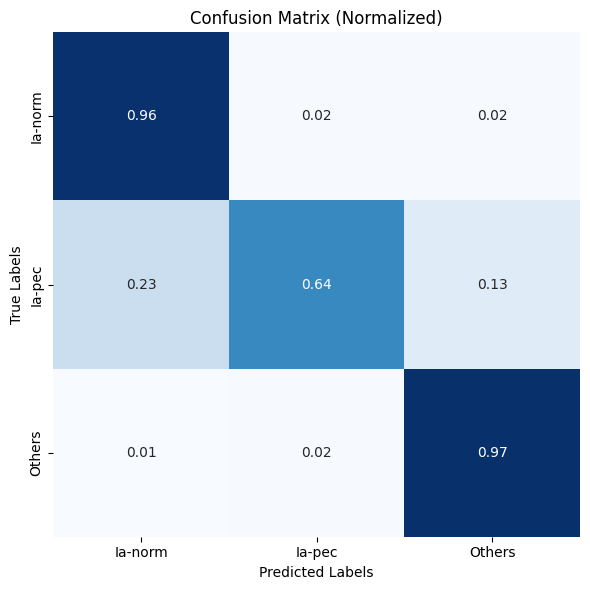

Loading augmented_images_v2.0_20x20...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 1/200 | Train L/A/F1: 1.1027 0.3228 0.2591 | Val L/A/F1: 1.1229 0.2273 0.1974
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 2/200 | Train L/A/F1: 1.0803 0.4311 0.4086 | Val L/A/F1: 1.0828 0.5455 0.4354
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 3/200 | Train L/A/F1: 0.9221 0.6807 0.6733 | Val L/A/F1: 0.9106 0.6798 0.6211
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.91it/s]


Epoch 4/200 | Train L/A/F1: 0.6436 0.7918 0.7888 | Val L/A/F1: 0.7580 0.7541 0.6919
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 5/200 | Train L/A/F1: 0.4534 0.8504 0.8495 | Val L/A/F1: 0.6325 0.7727 0.6968
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 6/200 | Train L/A/F1: 0.3343 0.8903 0.8896 | Val L/A/F1: 0.7871 0.7727 0.7269
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 7/200 | Train L/A/F1: 0.2526 0.9171 0.9168 | Val L/A/F1: 0.6994 0.7645 0.7360
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 8/200 | Train L/A/F1: 0.1853 0.9428 0.9426 | Val L/A/F1: 0.7975 0.7913 0.7590
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 9/200 | Train L/A/F1: 0.1483 0.9538 0.9537 | Val L/A/F1: 1.0101 0.7583 0.7067
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 10/200 | Train L/A/F1: 0.1194 0.9638 0.9637 | Val L/A/F1: 1.1438 0.7045 0.6781
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.62it/s]


Epoch 11/200 | Train L/A/F1: 0.0907 0.9732 0.9732 | Val L/A/F1: 0.9954 0.7831 0.7462
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 12/200 | Train L/A/F1: 0.0775 0.9778 0.9777 | Val L/A/F1: 1.1554 0.7417 0.7031
Epoch 12 | LR = 1.00e-05
Early stopping after 12 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.9286    0.8560    0.8908       243
      Ia-pec     0.5455    0.7579    0.6344        95
      Others     0.8047    0.7055    0.7518       146

    accuracy                         0.7913       484
   macro avg     0.7596    0.7731    0.7590       484
weighted avg     0.8160    0.7913    0.7985       484



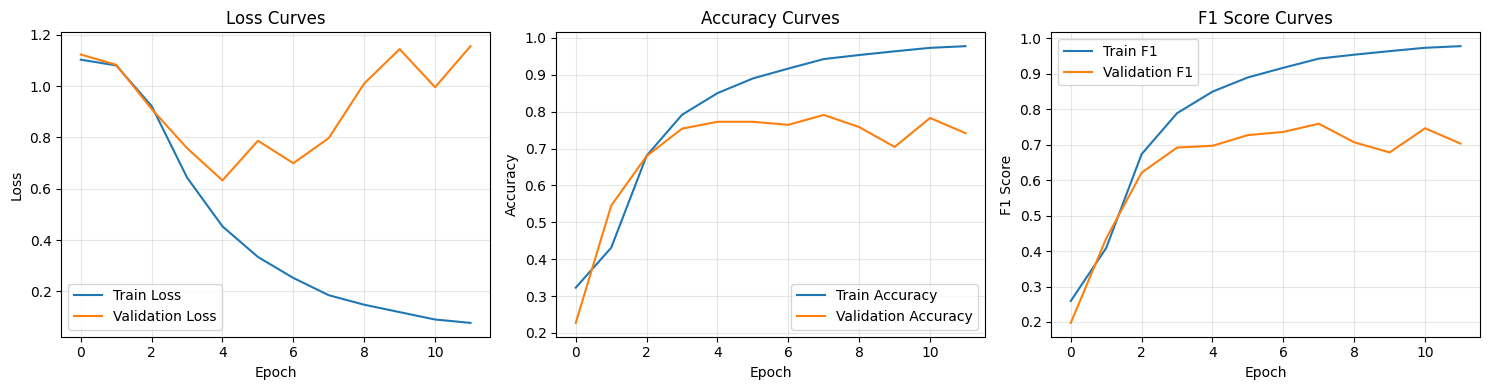

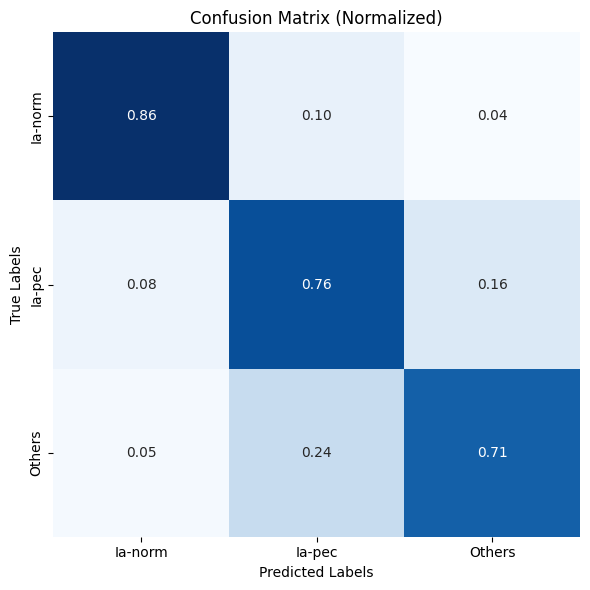

Loading augmented_images_v2.0_20x20...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.92it/s]


Epoch 1/200 | Train L/A/F1: 1.1028 0.3165 0.2539 | Val L/A/F1: 1.1221 0.2128 0.1718
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 2/200 | Train L/A/F1: 1.0794 0.4301 0.4151 | Val L/A/F1: 1.0738 0.5950 0.4760
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 3/200 | Train L/A/F1: 0.9191 0.6821 0.6723 | Val L/A/F1: 0.9800 0.5744 0.4313
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 4/200 | Train L/A/F1: 0.6504 0.7825 0.7793 | Val L/A/F1: 0.6608 0.7562 0.7083
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 5/200 | Train L/A/F1: 0.4527 0.8488 0.8477 | Val L/A/F1: 0.4893 0.8202 0.7531
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 6/200 | Train L/A/F1: 0.3355 0.8863 0.8857 | Val L/A/F1: 0.4695 0.8244 0.7766
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 7/200 | Train L/A/F1: 0.2425 0.9206 0.9203 | Val L/A/F1: 0.4903 0.8285 0.7972
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 8/200 | Train L/A/F1: 0.1829 0.9389 0.9388 | Val L/A/F1: 0.7323 0.7500 0.7099
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 9/200 | Train L/A/F1: 0.1281 0.9587 0.9586 | Val L/A/F1: 0.6659 0.7831 0.7465
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 10/200 | Train L/A/F1: 0.0914 0.9748 0.9748 | Val L/A/F1: 0.5703 0.8264 0.7784
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 11/200 | Train L/A/F1: 0.0844 0.9739 0.9739 | Val L/A/F1: 0.8641 0.7707 0.7472
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 12/200 | Train L/A/F1: 0.0630 0.9809 0.9809 | Val L/A/F1: 0.6020 0.8326 0.8067
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 13/200 | Train L/A/F1: 0.0557 0.9841 0.9841 | Val L/A/F1: 0.7406 0.8037 0.7706
Epoch 13 | LR = 1.00e-05
Early stopping after 13 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.8696    0.9053    0.8871       243
      Ia-pec     0.7113    0.7263    0.7188        95
      Others     0.8507    0.7808    0.8143       146

    accuracy                         0.8326       484
   macro avg     0.8106    0.8042    0.8067       484
weighted avg     0.8328    0.8326    0.8321       484



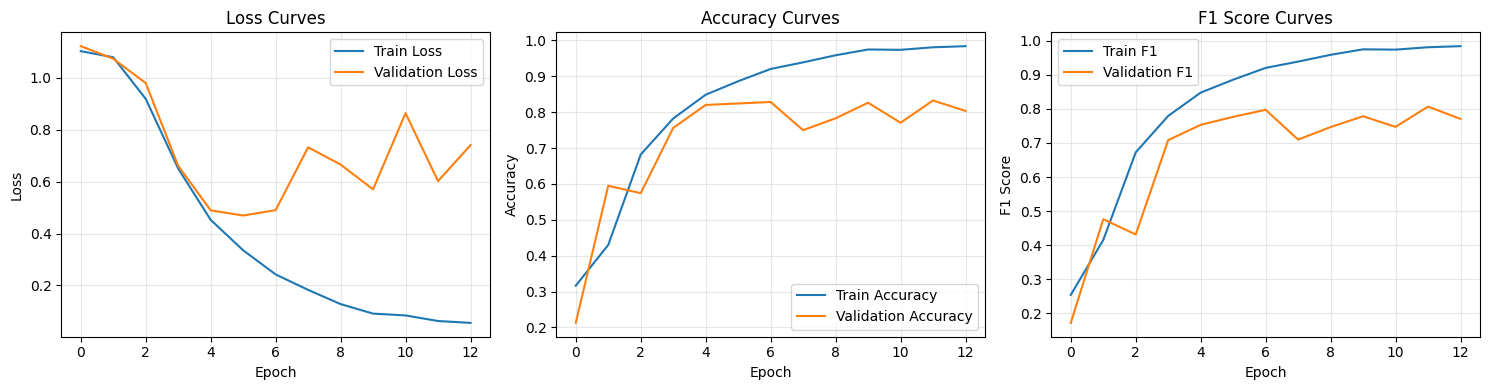

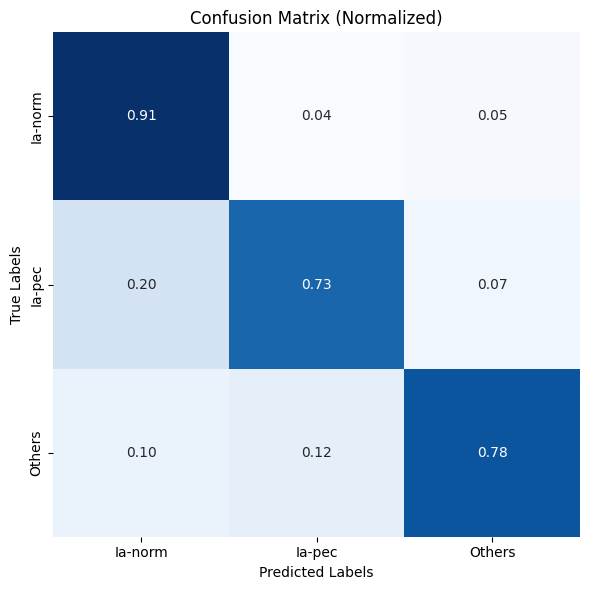

Loading augmented_images_v2.0_20x20...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.90it/s]


Epoch 1/200 | Train L/A/F1: 1.1027 0.3190 0.2567 | Val L/A/F1: 1.1223 0.2231 0.1920
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 2/200 | Train L/A/F1: 1.0799 0.4327 0.4166 | Val L/A/F1: 1.0762 0.5599 0.4324
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 3/200 | Train L/A/F1: 0.9232 0.6829 0.6719 | Val L/A/F1: 0.9141 0.6384 0.5311
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 4/200 | Train L/A/F1: 0.6575 0.7787 0.7755 | Val L/A/F1: 0.7444 0.7190 0.6096
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 5/200 | Train L/A/F1: 0.4495 0.8457 0.8447 | Val L/A/F1: 0.9529 0.6488 0.5397
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 6/200 | Train L/A/F1: 0.3223 0.8887 0.8881 | Val L/A/F1: 0.9299 0.6674 0.5788
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 7/200 | Train L/A/F1: 0.2361 0.9237 0.9235 | Val L/A/F1: 0.5981 0.7769 0.7233
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 8/200 | Train L/A/F1: 0.1772 0.9421 0.9420 | Val L/A/F1: 0.8270 0.6983 0.6580
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 9/200 | Train L/A/F1: 0.1598 0.9494 0.9494 | Val L/A/F1: 0.6578 0.7748 0.7351
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 10/200 | Train L/A/F1: 0.1207 0.9638 0.9637 | Val L/A/F1: 0.7746 0.7541 0.7156
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 11/200 | Train L/A/F1: 0.0853 0.9760 0.9760 | Val L/A/F1: 0.8264 0.7500 0.6978
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 12/200 | Train L/A/F1: 0.0751 0.9790 0.9790 | Val L/A/F1: 0.7760 0.7583 0.7155
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 13/200 | Train L/A/F1: 0.0604 0.9822 0.9821 | Val L/A/F1: 1.0220 0.7314 0.6883
Epoch 13 | LR = 1.00e-05


Epoch 14/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 14/200 | Train L/A/F1: 0.0516 0.9862 0.9862 | Val L/A/F1: 1.0593 0.7293 0.6719
Epoch 14 | LR = 1.00e-05
Early stopping after 14 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.8140    0.8642    0.8383       243
      Ia-pec     0.5761    0.5579    0.5668        95
      Others     0.8358    0.7671    0.8000       146

    accuracy                         0.7748       484
   macro avg     0.7420    0.7297    0.7351       484
weighted avg     0.7739    0.7748    0.7735       484



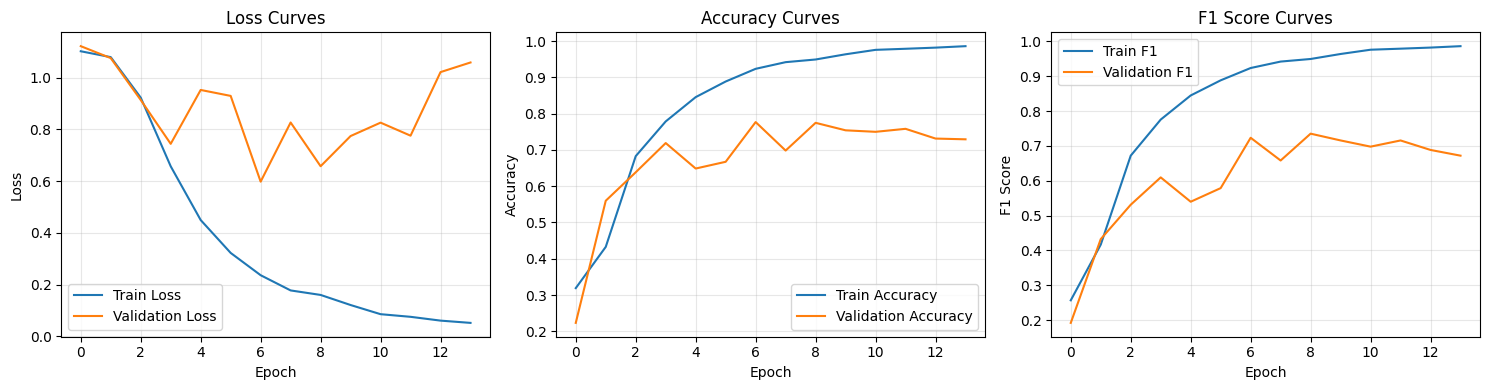

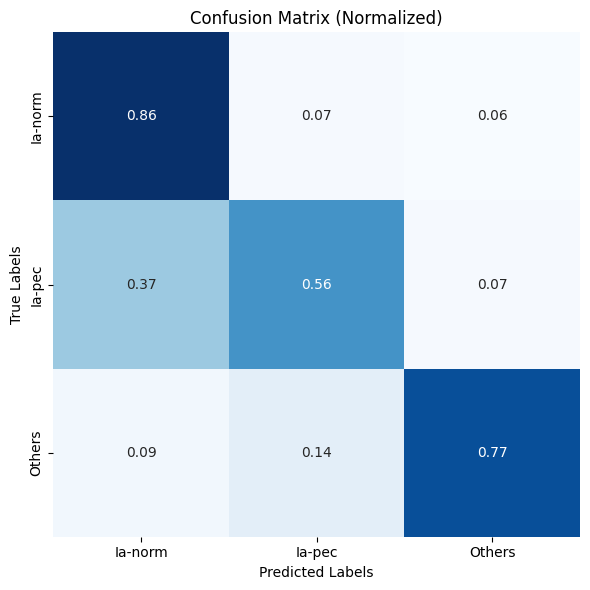

Loading augmented_images_v2.0_20x20_n...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 1/200 | Train L/A/F1: 1.1028 0.3172 0.2454 | Val L/A/F1: 1.1189 0.2810 0.1905
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 2/200 | Train L/A/F1: 1.0699 0.4609 0.4591 | Val L/A/F1: 1.0542 0.5909 0.4767
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 3/200 | Train L/A/F1: 0.9259 0.6336 0.6201 | Val L/A/F1: 0.9303 0.6384 0.5280
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 4/200 | Train L/A/F1: 0.7256 0.7398 0.7339 | Val L/A/F1: 0.7521 0.7211 0.6490
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 5/200 | Train L/A/F1: 0.5225 0.8177 0.8156 | Val L/A/F1: 0.6631 0.7686 0.7000
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 6/200 | Train L/A/F1: 0.4081 0.8630 0.8619 | Val L/A/F1: 0.5545 0.7810 0.7254
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 7/200 | Train L/A/F1: 0.3188 0.8919 0.8912 | Val L/A/F1: 0.6452 0.7417 0.7157
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 8/200 | Train L/A/F1: 0.2589 0.9134 0.9130 | Val L/A/F1: 0.5993 0.7955 0.7555
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 9/200 | Train L/A/F1: 0.2131 0.9290 0.9288 | Val L/A/F1: 0.6516 0.7934 0.7546
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 10/200 | Train L/A/F1: 0.1732 0.9433 0.9432 | Val L/A/F1: 0.6091 0.8120 0.7776
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 11/200 | Train L/A/F1: 0.1485 0.9524 0.9523 | Val L/A/F1: 0.8671 0.7355 0.7112
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 12/200 | Train L/A/F1: 0.1253 0.9594 0.9594 | Val L/A/F1: 0.6947 0.8099 0.7781
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 13/200 | Train L/A/F1: 0.1010 0.9696 0.9695 | Val L/A/F1: 0.8327 0.7789 0.7442
Epoch 13 | LR = 1.00e-05
Early stopping after 13 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.9244    0.8560    0.8889       243
      Ia-pec     0.6168    0.6947    0.6535        95
      Others     0.7763    0.8082    0.7919       146

    accuracy                         0.8099       484
   macro avg     0.7725    0.7863    0.7781       484
weighted avg     0.8194    0.8099    0.8134       484



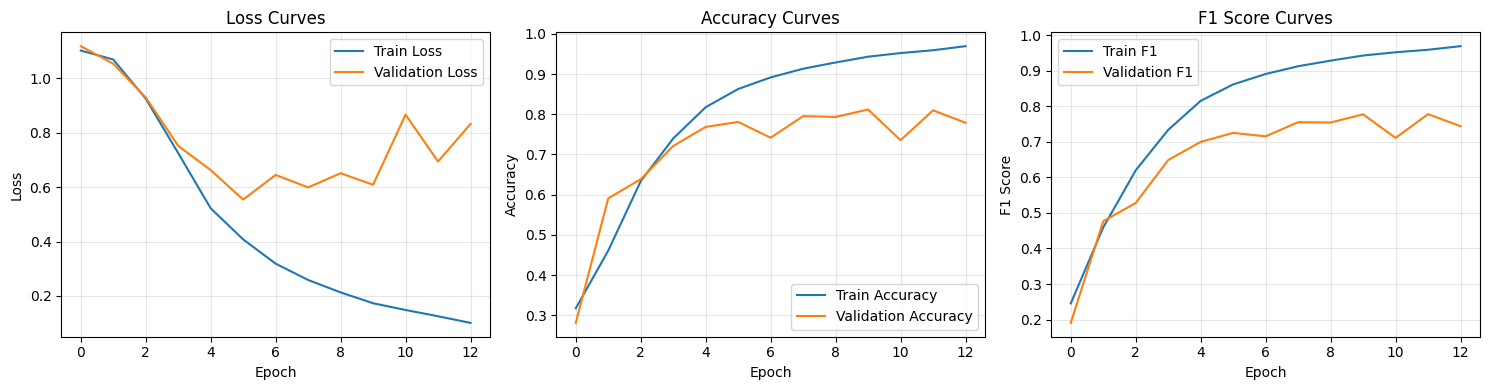

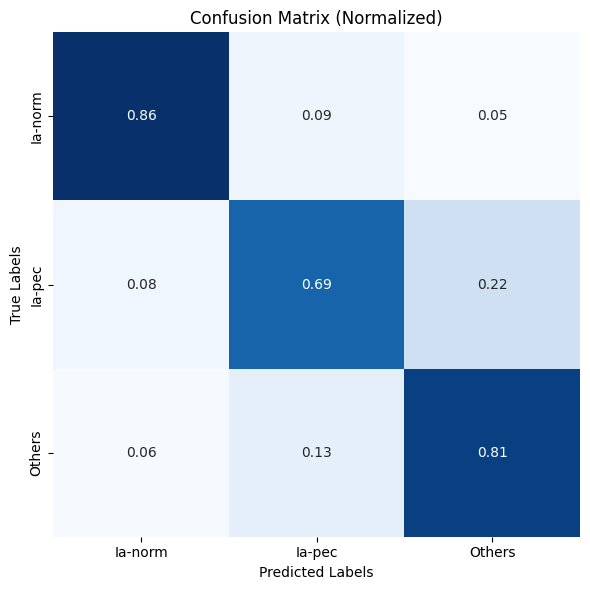

Loading augmented_images_v2.0_20x20_n...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 1/200 | Train L/A/F1: 1.1028 0.3214 0.2491 | Val L/A/F1: 1.1183 0.2686 0.1774
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 2/200 | Train L/A/F1: 1.0702 0.4612 0.4582 | Val L/A/F1: 1.0372 0.6136 0.5024
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 3/200 | Train L/A/F1: 0.9316 0.6315 0.6159 | Val L/A/F1: 0.9130 0.6281 0.4984
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 4/200 | Train L/A/F1: 0.7361 0.7279 0.7206 | Val L/A/F1: 0.8004 0.7004 0.6133
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 5/200 | Train L/A/F1: 0.5277 0.8136 0.8118 | Val L/A/F1: 0.5977 0.7645 0.6854
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 6/200 | Train L/A/F1: 0.3903 0.8630 0.8618 | Val L/A/F1: 0.5572 0.7851 0.7408
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 7/200 | Train L/A/F1: 0.3220 0.8892 0.8886 | Val L/A/F1: 0.6348 0.7748 0.7371
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 8/200 | Train L/A/F1: 0.2668 0.9078 0.9074 | Val L/A/F1: 0.7531 0.7521 0.6961
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 9/200 | Train L/A/F1: 0.2104 0.9318 0.9317 | Val L/A/F1: 0.5709 0.8223 0.7907
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 10/200 | Train L/A/F1: 0.1576 0.9507 0.9506 | Val L/A/F1: 0.6053 0.7851 0.7566
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 11/200 | Train L/A/F1: 0.1438 0.9521 0.9520 | Val L/A/F1: 0.5460 0.8306 0.8053
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 12/200 | Train L/A/F1: 0.1065 0.9683 0.9683 | Val L/A/F1: 0.7969 0.7603 0.7363
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 13/200 | Train L/A/F1: 0.1005 0.9692 0.9692 | Val L/A/F1: 0.9720 0.7397 0.6823
Epoch 13 | LR = 1.00e-05


Epoch 14/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 14/200 | Train L/A/F1: 0.0784 0.9752 0.9751 | Val L/A/F1: 0.5990 0.8037 0.7664
Epoch 14 | LR = 1.00e-05


Epoch 15/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 15/200 | Train L/A/F1: 0.0691 0.9794 0.9793 | Val L/A/F1: 0.7045 0.8140 0.7837
Epoch 15 | LR = 1.00e-05


Epoch 16/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 16/200 | Train L/A/F1: 0.0515 0.9857 0.9856 | Val L/A/F1: 0.6708 0.8326 0.8028
Epoch 16 | LR = 1.00e-05


Epoch 17/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 17/200 | Train L/A/F1: 0.0583 0.9825 0.9825 | Val L/A/F1: 0.6088 0.8368 0.8040
Epoch 17 | LR = 1.00e-05


Epoch 18/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 18/200 | Train L/A/F1: 0.0617 0.9802 0.9802 | Val L/A/F1: 0.6171 0.8409 0.8114
Epoch 18 | LR = 1.00e-05
Early stopping after 18 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.8481    0.9424    0.8928       243
      Ia-pec     0.7386    0.6842    0.7104        95
      Others     0.8968    0.7740    0.8309       146

    accuracy                         0.8409       484
   macro avg     0.8279    0.8002    0.8114       484
weighted avg     0.8413    0.8409    0.8383       484



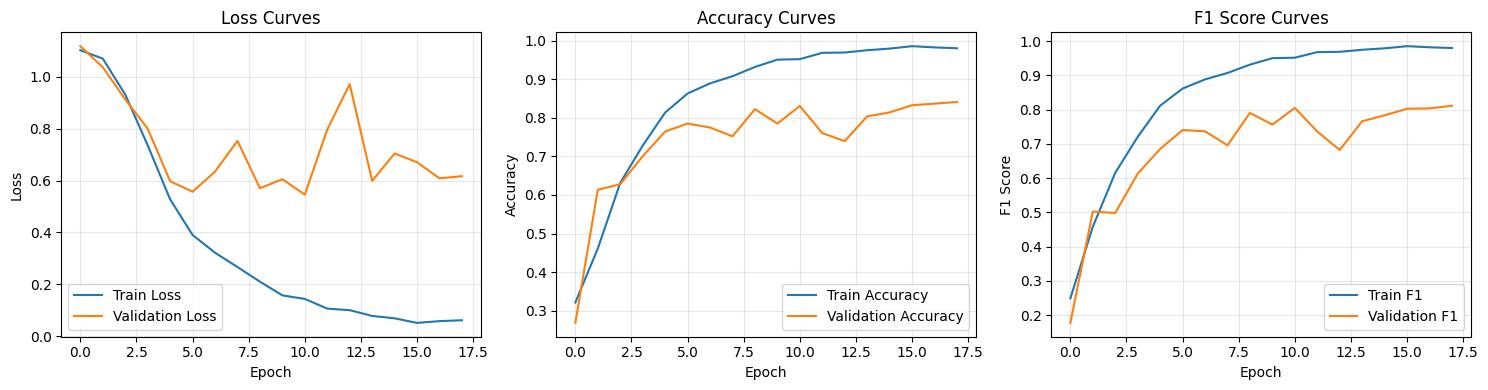

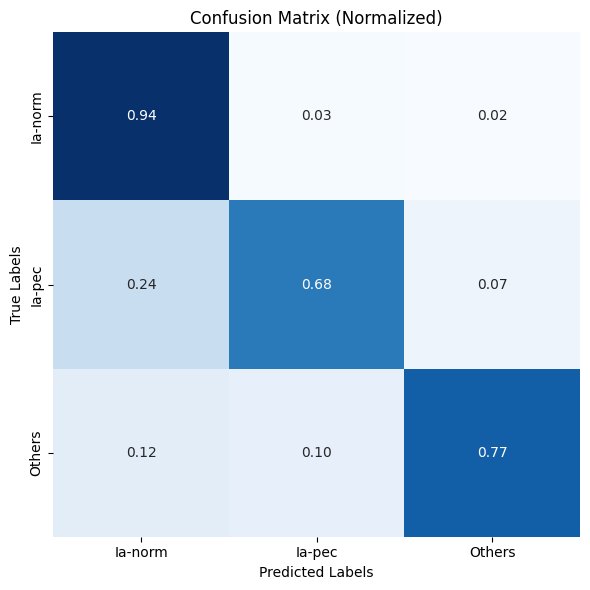

Loading augmented_images_v2.0_20x20_n...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.92it/s]


Epoch 1/200 | Train L/A/F1: 1.1027 0.3235 0.2504 | Val L/A/F1: 1.1183 0.2727 0.1857
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 2/200 | Train L/A/F1: 1.0691 0.4691 0.4672 | Val L/A/F1: 1.0484 0.5764 0.4460
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 3/200 | Train L/A/F1: 0.9252 0.6395 0.6272 | Val L/A/F1: 0.9348 0.6260 0.5077
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 4/200 | Train L/A/F1: 0.7140 0.7414 0.7349 | Val L/A/F1: 0.8308 0.6653 0.5496
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 5/200 | Train L/A/F1: 0.5308 0.8150 0.8127 | Val L/A/F1: 0.6883 0.7397 0.6734
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 6/200 | Train L/A/F1: 0.3869 0.8640 0.8630 | Val L/A/F1: 0.8311 0.6736 0.6366
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 7/200 | Train L/A/F1: 0.3227 0.8866 0.8860 | Val L/A/F1: 0.6653 0.7417 0.6967
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 8/200 | Train L/A/F1: 0.2432 0.9186 0.9183 | Val L/A/F1: 0.8829 0.6901 0.6177
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 9/200 | Train L/A/F1: 0.2154 0.9281 0.9279 | Val L/A/F1: 0.6593 0.7686 0.7107
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 10/200 | Train L/A/F1: 0.1787 0.9412 0.9411 | Val L/A/F1: 0.6965 0.7665 0.7254
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 11/200 | Train L/A/F1: 0.1459 0.9540 0.9539 | Val L/A/F1: 0.7333 0.7500 0.7323
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 12/200 | Train L/A/F1: 0.1243 0.9599 0.9599 | Val L/A/F1: 0.7155 0.7727 0.7448
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 13/200 | Train L/A/F1: 0.0915 0.9727 0.9727 | Val L/A/F1: 0.7770 0.7624 0.7286
Epoch 13 | LR = 1.00e-05


Epoch 14/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 14/200 | Train L/A/F1: 0.0767 0.9757 0.9757 | Val L/A/F1: 0.7461 0.7996 0.7737
Epoch 14 | LR = 1.00e-05


Epoch 15/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 15/200 | Train L/A/F1: 0.0706 0.9795 0.9795 | Val L/A/F1: 0.8573 0.7645 0.7303
Epoch 15 | LR = 1.00e-05


Epoch 16/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 16/200 | Train L/A/F1: 0.0734 0.9781 0.9781 | Val L/A/F1: 0.7883 0.7562 0.7114
Epoch 16 | LR = 1.00e-05
Early stopping after 16 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.8108    0.8642    0.8367       243
      Ia-pec     0.6703    0.6421    0.6559        95
      Others     0.8657    0.7945    0.8286       146

    accuracy                         0.7996       484
   macro avg     0.7823    0.7669    0.7737       484
weighted avg     0.7998    0.7996    0.7987       484



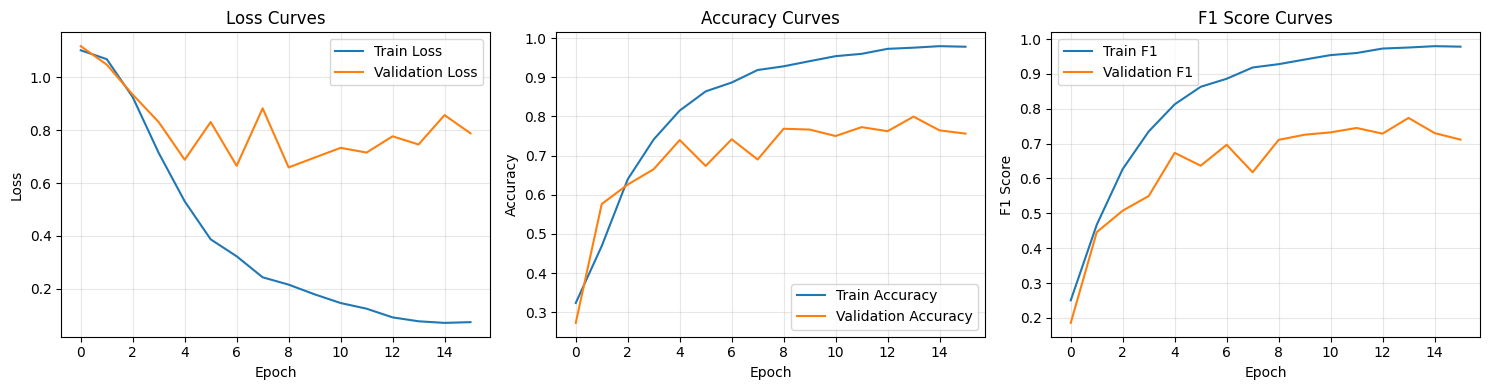

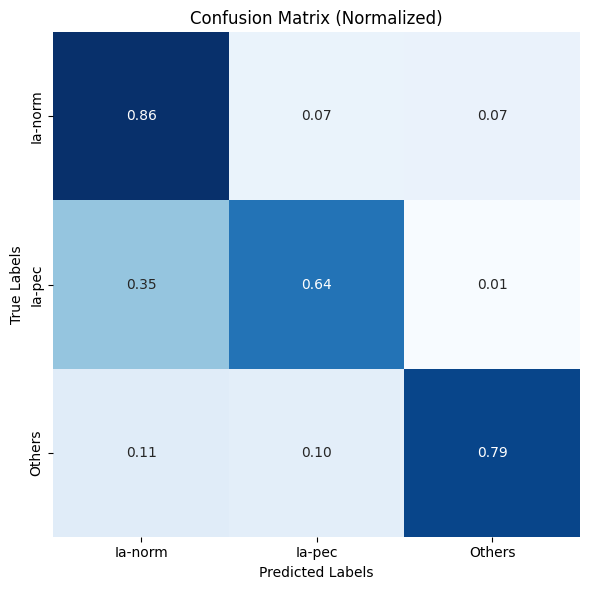

Loading augmented_images_v2.0_224x112...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 1/200 | Train L/A/F1: 1.1055 0.3200 0.2051 | Val L/A/F1: 1.1096 0.2996 0.1537
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 2/200 | Train L/A/F1: 1.0804 0.4205 0.3793 | Val L/A/F1: 1.0735 0.5868 0.4723
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 3/200 | Train L/A/F1: 0.9178 0.7111 0.7059 | Val L/A/F1: 0.8893 0.6612 0.5563
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 4/200 | Train L/A/F1: 0.5691 0.8331 0.8311 | Val L/A/F1: 0.6292 0.7748 0.6849
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 5/200 | Train L/A/F1: 0.3460 0.8898 0.8889 | Val L/A/F1: 0.5336 0.7913 0.7464
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 6/200 | Train L/A/F1: 0.2247 0.9290 0.9287 | Val L/A/F1: 0.5283 0.8037 0.7436
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 7/200 | Train L/A/F1: 0.1540 0.9545 0.9544 | Val L/A/F1: 0.5182 0.8161 0.7912
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 8/200 | Train L/A/F1: 0.1037 0.9718 0.9718 | Val L/A/F1: 0.5225 0.8306 0.7783
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 9/200 | Train L/A/F1: 0.0819 0.9780 0.9779 | Val L/A/F1: 0.7004 0.8058 0.7672
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 10/200 | Train L/A/F1: 0.0422 0.9925 0.9925 | Val L/A/F1: 0.8647 0.7831 0.7638
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 11/200 | Train L/A/F1: 0.0320 0.9935 0.9935 | Val L/A/F1: 0.7950 0.7975 0.7681
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.91it/s]


Epoch 12/200 | Train L/A/F1: 0.0311 0.9934 0.9933 | Val L/A/F1: 0.8401 0.7975 0.7428
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 13/200 | Train L/A/F1: 0.0379 0.9913 0.9912 | Val L/A/F1: 0.7169 0.8202 0.8010
Epoch 13 | LR = 1.00e-05


Epoch 14/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 14/200 | Train L/A/F1: 0.0241 0.9949 0.9949 | Val L/A/F1: 0.7301 0.8079 0.7809
Epoch 14 | LR = 1.00e-05
Early stopping after 14 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.9366    0.7901    0.8571       243
      Ia-pec     0.5781    0.7789    0.6637        95
      Others     0.8675    0.8973    0.8822       146

    accuracy                         0.8202       484
   macro avg     0.7941    0.8221    0.8010       484
weighted avg     0.8454    0.8202    0.8267       484



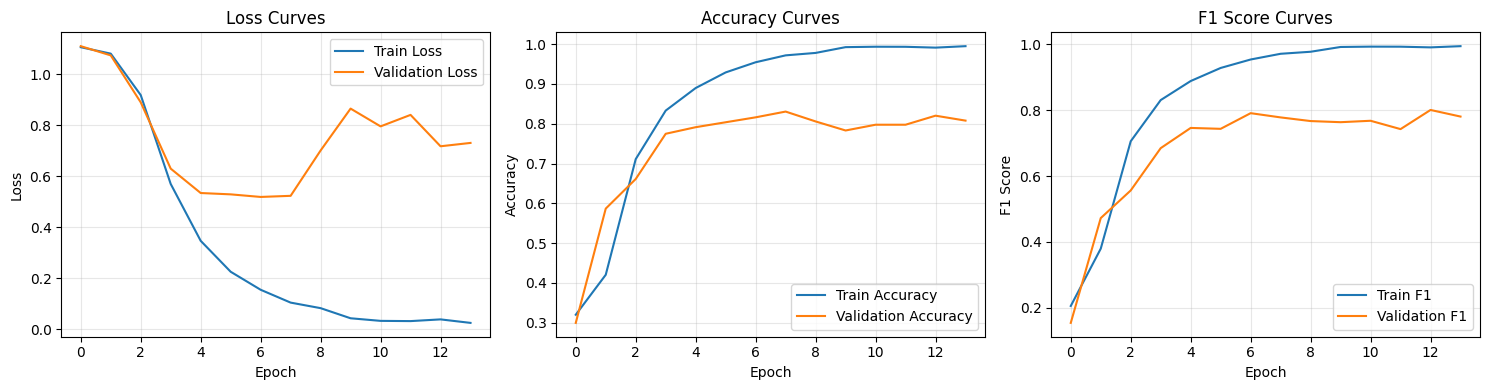

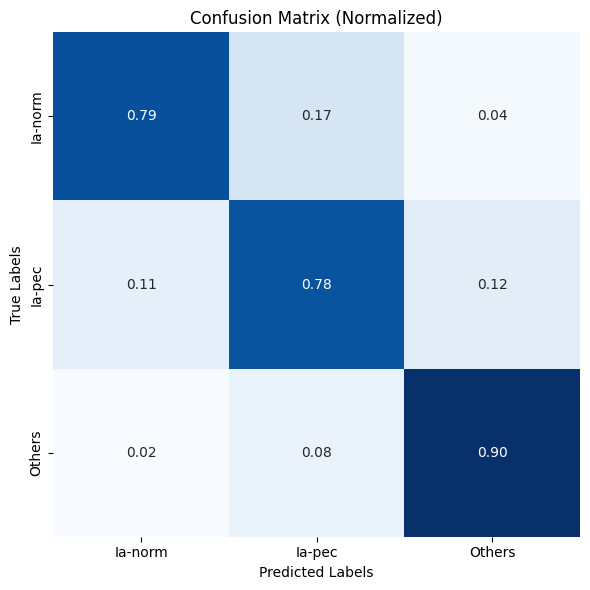

Loading augmented_images_v2.0_224x112...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 1/200 | Train L/A/F1: 1.1058 0.3204 0.2036 | Val L/A/F1: 1.1114 0.2996 0.1537
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 2/200 | Train L/A/F1: 1.0803 0.4255 0.3886 | Val L/A/F1: 1.0688 0.6570 0.5626
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 3/200 | Train L/A/F1: 0.9238 0.7090 0.7020 | Val L/A/F1: 0.8542 0.7169 0.6052
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 4/200 | Train L/A/F1: 0.5790 0.8278 0.8252 | Val L/A/F1: 0.6052 0.7831 0.7249
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 5/200 | Train L/A/F1: 0.3598 0.8817 0.8808 | Val L/A/F1: 0.5210 0.7934 0.7343
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 6/200 | Train L/A/F1: 0.2429 0.9209 0.9204 | Val L/A/F1: 0.5073 0.8368 0.8042
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 7/200 | Train L/A/F1: 0.1706 0.9470 0.9468 | Val L/A/F1: 0.5048 0.8430 0.8095
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.91it/s]


Epoch 8/200 | Train L/A/F1: 0.1120 0.9694 0.9693 | Val L/A/F1: 0.7959 0.7603 0.7035
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 9/200 | Train L/A/F1: 0.0853 0.9788 0.9788 | Val L/A/F1: 0.4873 0.8554 0.8253
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 10/200 | Train L/A/F1: 0.0601 0.9848 0.9848 | Val L/A/F1: 0.6532 0.8223 0.7964
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 11/200 | Train L/A/F1: 0.0431 0.9897 0.9897 | Val L/A/F1: 0.5799 0.8450 0.8160
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 12/200 | Train L/A/F1: 0.0479 0.9874 0.9874 | Val L/A/F1: 1.1464 0.7417 0.6937
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 13/200 | Train L/A/F1: 0.0231 0.9965 0.9965 | Val L/A/F1: 0.6303 0.8430 0.8199
Epoch 13 | LR = 1.00e-05


Epoch 14/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 14/200 | Train L/A/F1: 0.0138 0.9972 0.9972 | Val L/A/F1: 0.8946 0.8037 0.7847
Epoch 14 | LR = 1.00e-05


Epoch 15/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 15/200 | Train L/A/F1: 0.0294 0.9914 0.9914 | Val L/A/F1: 0.7761 0.8326 0.8019
Epoch 15 | LR = 1.00e-05


Epoch 16/200: 100%|██████████| 179/179 [00:16<00:00, 10.92it/s]


Epoch 16/200 | Train L/A/F1: 0.0207 0.9949 0.9949 | Val L/A/F1: 0.8269 0.8430 0.8146
Epoch 16 | LR = 1.00e-05
Early stopping after 16 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.8582    0.9218    0.8889       243
      Ia-pec     0.7692    0.6316    0.6936        95
      Others     0.8966    0.8904    0.8935       146

    accuracy                         0.8554       484
   macro avg     0.8413    0.8146    0.8253       484
weighted avg     0.8523    0.8554    0.8519       484



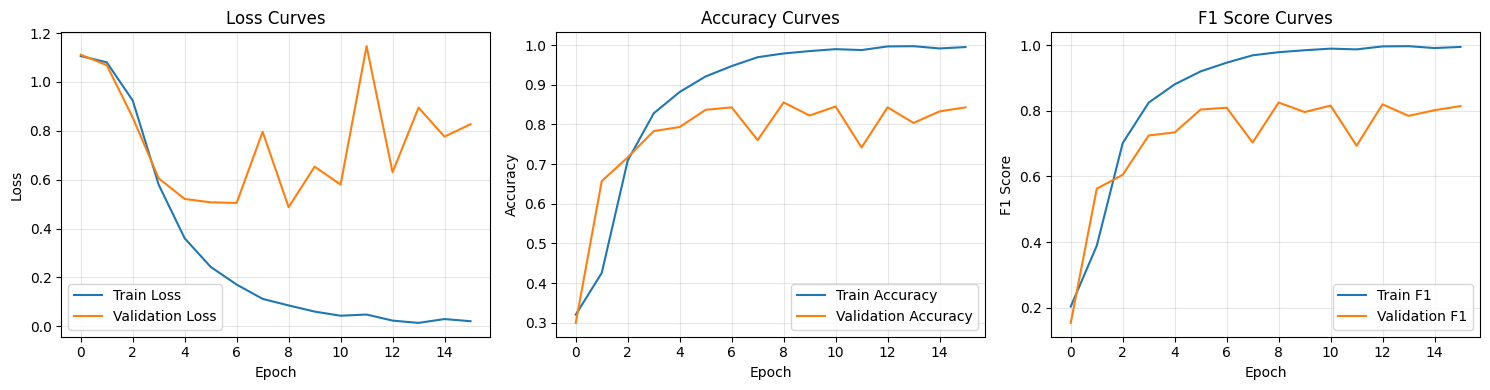

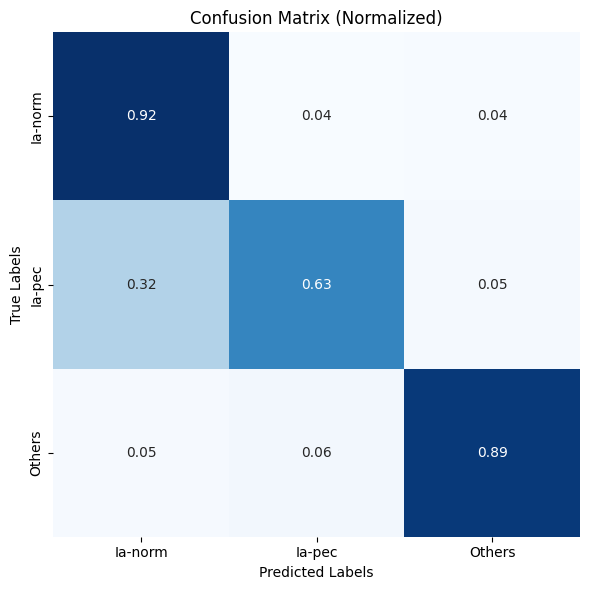

Loading augmented_images_v2.0_224x112...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.92it/s]


Epoch 1/200 | Train L/A/F1: 1.1055 0.3242 0.2094 | Val L/A/F1: 1.1132 0.2975 0.1529
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 2/200 | Train L/A/F1: 1.0794 0.4234 0.3837 | Val L/A/F1: 1.0744 0.6116 0.4793
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 3/200 | Train L/A/F1: 0.9190 0.7132 0.7061 | Val L/A/F1: 0.8815 0.7045 0.6121
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 4/200 | Train L/A/F1: 0.5735 0.8341 0.8318 | Val L/A/F1: 0.6655 0.7459 0.6642
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 5/200 | Train L/A/F1: 0.3573 0.8864 0.8858 | Val L/A/F1: 0.6034 0.7624 0.7047
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 6/200 | Train L/A/F1: 0.2324 0.9265 0.9262 | Val L/A/F1: 0.5572 0.7893 0.7394
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 7/200 | Train L/A/F1: 0.1554 0.9561 0.9560 | Val L/A/F1: 0.7637 0.7252 0.6765
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 8/200 | Train L/A/F1: 0.1001 0.9734 0.9734 | Val L/A/F1: 0.6940 0.7645 0.7321
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.91it/s]


Epoch 9/200 | Train L/A/F1: 0.0811 0.9794 0.9793 | Val L/A/F1: 0.6529 0.7810 0.7167
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 10/200 | Train L/A/F1: 0.0510 0.9890 0.9890 | Val L/A/F1: 0.7611 0.7727 0.7240
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.92it/s]


Epoch 11/200 | Train L/A/F1: 0.0411 0.9918 0.9918 | Val L/A/F1: 0.9225 0.7541 0.7137
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 12/200 | Train L/A/F1: 0.0457 0.9881 0.9881 | Val L/A/F1: 0.9551 0.7603 0.7170
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 13/200 | Train L/A/F1: 0.0361 0.9921 0.9921 | Val L/A/F1: 0.8214 0.7934 0.7461
Epoch 13 | LR = 1.00e-05
Early stopping after 13 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.8022    0.9012    0.8488       243
      Ia-pec     0.5595    0.4947    0.5251        95
      Others     0.9291    0.8082    0.8645       146

    accuracy                         0.7934       484
   macro avg     0.7636    0.7347    0.7461       484
weighted avg     0.7929    0.7934    0.7900       484



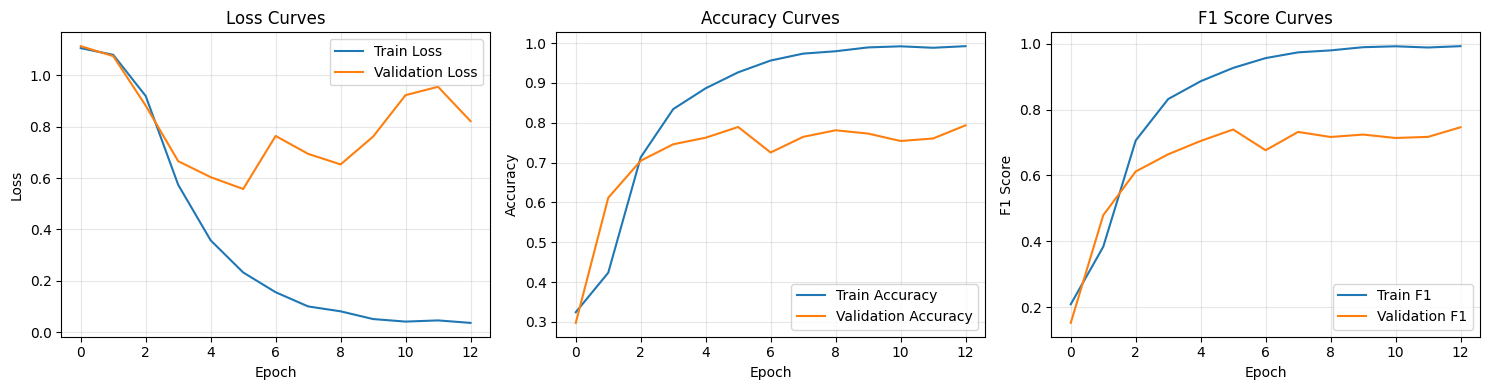

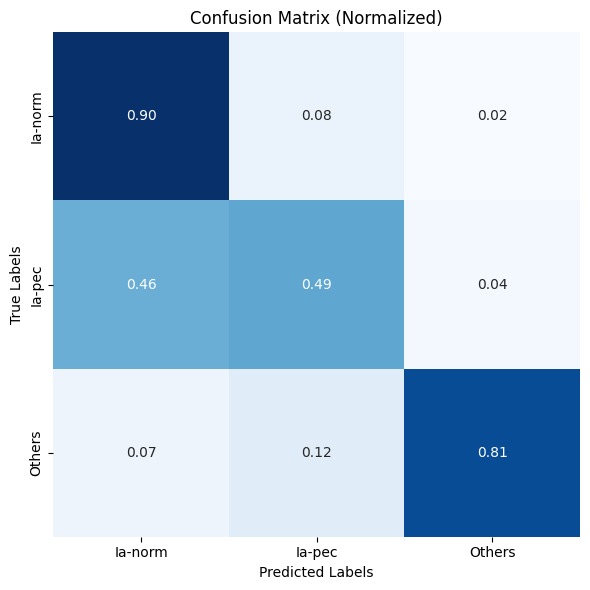

Loading augmented_images_v2.0_224x112_n...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 1/200 | Train L/A/F1: 1.0997 0.3265 0.2251 | Val L/A/F1: 1.1071 0.2996 0.1537
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 2/200 | Train L/A/F1: 1.0662 0.4829 0.4698 | Val L/A/F1: 1.0590 0.5930 0.4853
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 3/200 | Train L/A/F1: 0.8862 0.7081 0.6999 | Val L/A/F1: 0.8749 0.6860 0.5977
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 4/200 | Train L/A/F1: 0.6040 0.8110 0.8090 | Val L/A/F1: 0.7482 0.7231 0.6322
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.91it/s]


Epoch 5/200 | Train L/A/F1: 0.4200 0.8637 0.8627 | Val L/A/F1: 0.6238 0.7769 0.7011
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 6/200 | Train L/A/F1: 0.3365 0.8857 0.8852 | Val L/A/F1: 0.5950 0.7975 0.7586
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 7/200 | Train L/A/F1: 0.2510 0.9176 0.9173 | Val L/A/F1: 0.5827 0.7934 0.7300
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 8/200 | Train L/A/F1: 0.1996 0.9354 0.9352 | Val L/A/F1: 0.5659 0.8058 0.7710
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 9/200 | Train L/A/F1: 0.1702 0.9459 0.9458 | Val L/A/F1: 0.6293 0.7996 0.7638
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 10/200 | Train L/A/F1: 0.1340 0.9584 0.9583 | Val L/A/F1: 0.5002 0.8223 0.7721
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 11/200 | Train L/A/F1: 0.1071 0.9668 0.9667 | Val L/A/F1: 0.6040 0.8120 0.7776
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 12/200 | Train L/A/F1: 0.0753 0.9778 0.9778 | Val L/A/F1: 0.6833 0.8079 0.7619
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 13/200 | Train L/A/F1: 0.0486 0.9876 0.9876 | Val L/A/F1: 0.6275 0.8099 0.7704
Epoch 13 | LR = 1.00e-05


Epoch 14/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 14/200 | Train L/A/F1: 0.0551 0.9836 0.9835 | Val L/A/F1: 0.6735 0.8326 0.8042
Epoch 14 | LR = 1.00e-05


Epoch 15/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 15/200 | Train L/A/F1: 0.0438 0.9893 0.9893 | Val L/A/F1: 0.6169 0.8285 0.7980
Epoch 15 | LR = 1.00e-05


Epoch 16/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 16/200 | Train L/A/F1: 0.0263 0.9935 0.9935 | Val L/A/F1: 0.6829 0.8182 0.7800
Epoch 16 | LR = 1.00e-05


Epoch 17/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 17/200 | Train L/A/F1: 0.0457 0.9878 0.9877 | Val L/A/F1: 1.0374 0.7789 0.7069
Epoch 17 | LR = 1.00e-05
Early stopping after 17 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.8327    0.9218    0.8750       243
      Ia-pec     0.7381    0.6526    0.6927        95
      Others     0.8931    0.8014    0.8448       146

    accuracy                         0.8326       484
   macro avg     0.8213    0.7919    0.8042       484
weighted avg     0.8324    0.8326    0.8301       484



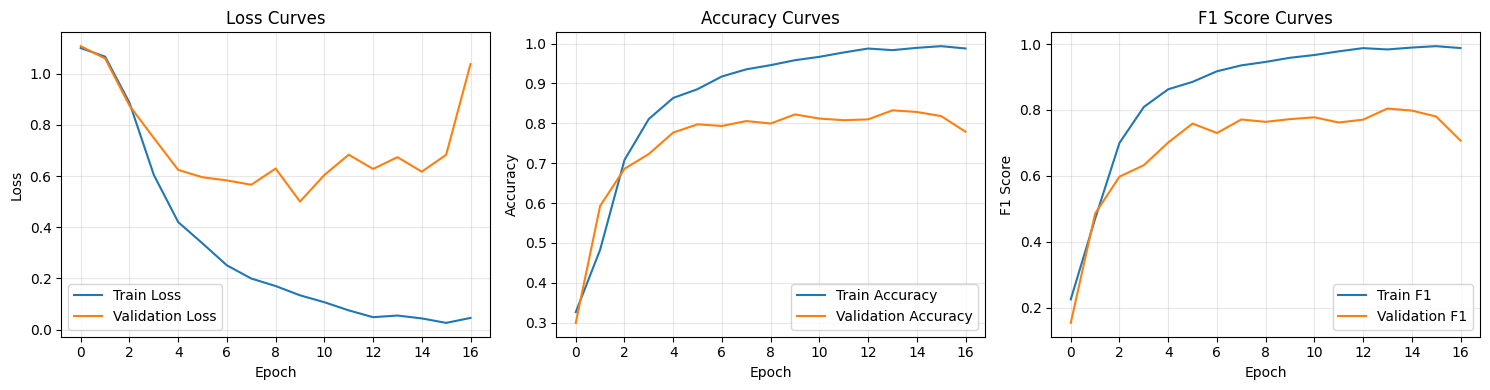

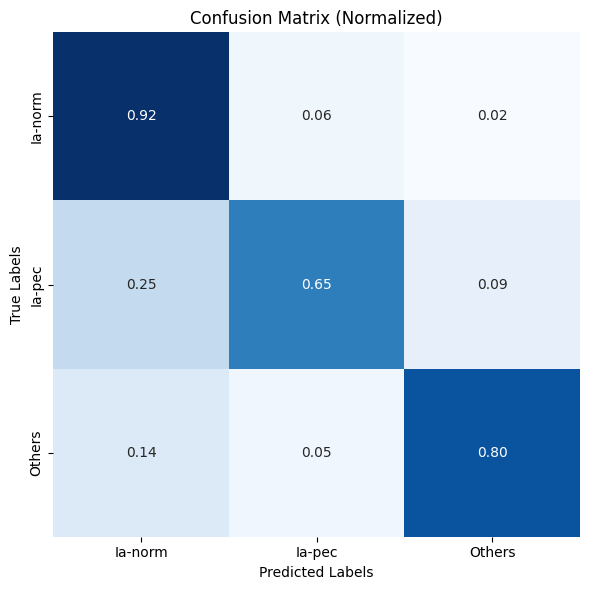

Loading augmented_images_v2.0_224x112_n...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.92it/s]


Epoch 1/200 | Train L/A/F1: 1.0996 0.3279 0.2253 | Val L/A/F1: 1.1063 0.2996 0.1537
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 2/200 | Train L/A/F1: 1.0661 0.4744 0.4621 | Val L/A/F1: 1.0483 0.5826 0.4393
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 3/200 | Train L/A/F1: 0.8893 0.7013 0.6920 | Val L/A/F1: 0.8234 0.6880 0.5504
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 4/200 | Train L/A/F1: 0.6035 0.8128 0.8107 | Val L/A/F1: 0.6694 0.7335 0.6842
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 5/200 | Train L/A/F1: 0.4071 0.8667 0.8658 | Val L/A/F1: 0.5063 0.8140 0.7329
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 6/200 | Train L/A/F1: 0.3144 0.8976 0.8971 | Val L/A/F1: 0.5977 0.7789 0.7240
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 7/200 | Train L/A/F1: 0.2391 0.9190 0.9188 | Val L/A/F1: 0.5901 0.7603 0.7292
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 8/200 | Train L/A/F1: 0.1899 0.9386 0.9384 | Val L/A/F1: 0.5593 0.8099 0.7386
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 9/200 | Train L/A/F1: 0.1648 0.9465 0.9463 | Val L/A/F1: 0.6112 0.7975 0.7466
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 10/200 | Train L/A/F1: 0.1190 0.9645 0.9644 | Val L/A/F1: 0.6570 0.7645 0.7207
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 11/200 | Train L/A/F1: 0.0947 0.9717 0.9716 | Val L/A/F1: 0.7329 0.7645 0.7278
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 12/200 | Train L/A/F1: 0.0789 0.9771 0.9771 | Val L/A/F1: 0.6102 0.8140 0.7710
Epoch 12 | LR = 1.00e-05
Early stopping after 12 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.8209    0.9053    0.8611       243
      Ia-pec     0.6579    0.5263    0.5848        95
      Others     0.8857    0.8493    0.8671       146

    accuracy                         0.8140       484
   macro avg     0.7882    0.7603    0.7710       484
weighted avg     0.8085    0.8140    0.8087       484



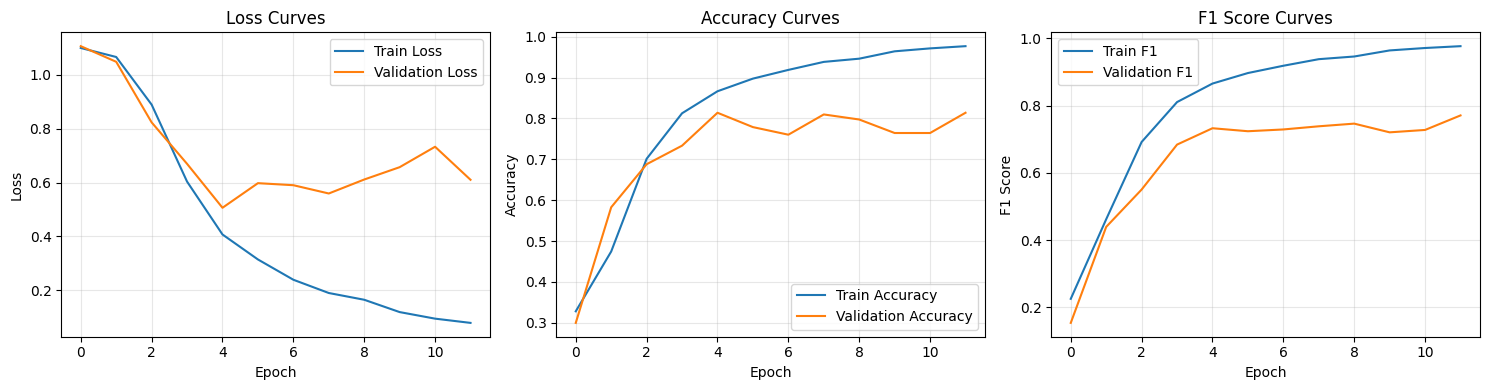

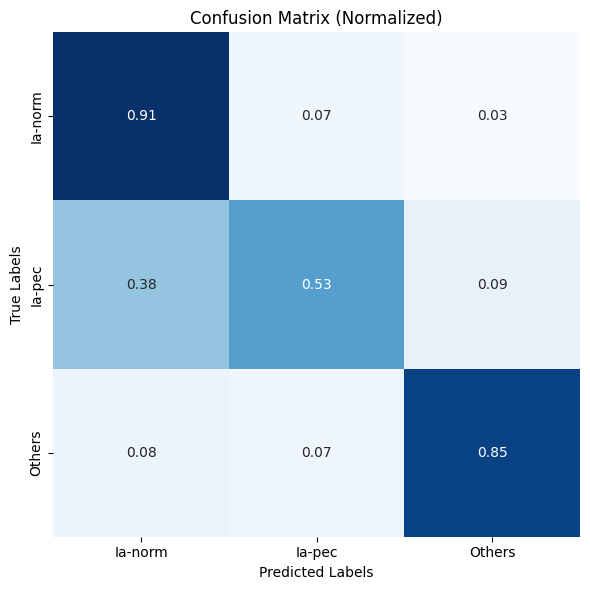

Loading augmented_images_v2.0_224x112_n...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 1/200 | Train L/A/F1: 1.0997 0.3279 0.2251 | Val L/A/F1: 1.1065 0.2996 0.1557
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 2/200 | Train L/A/F1: 1.0663 0.4772 0.4642 | Val L/A/F1: 1.0574 0.5517 0.4155
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 3/200 | Train L/A/F1: 0.8839 0.7094 0.6997 | Val L/A/F1: 0.9148 0.6116 0.4805
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 4/200 | Train L/A/F1: 0.5785 0.8259 0.8241 | Val L/A/F1: 0.7451 0.6983 0.5968
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 5/200 | Train L/A/F1: 0.4110 0.8663 0.8655 | Val L/A/F1: 0.7370 0.7169 0.6203
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 6/200 | Train L/A/F1: 0.3103 0.8966 0.8961 | Val L/A/F1: 0.6596 0.7335 0.6749
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 7/200 | Train L/A/F1: 0.2372 0.9211 0.9207 | Val L/A/F1: 0.5813 0.7789 0.7318
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 8/200 | Train L/A/F1: 0.2003 0.9382 0.9381 | Val L/A/F1: 0.6652 0.7583 0.7215
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 9/200 | Train L/A/F1: 0.1698 0.9454 0.9453 | Val L/A/F1: 0.6477 0.7562 0.6895
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 10/200 | Train L/A/F1: 0.1326 0.9589 0.9587 | Val L/A/F1: 0.6809 0.7686 0.7305
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 11/200 | Train L/A/F1: 0.1012 0.9722 0.9721 | Val L/A/F1: 0.7462 0.7645 0.7005
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 12/200 | Train L/A/F1: 0.0896 0.9725 0.9725 | Val L/A/F1: 0.7399 0.7727 0.7417
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 13/200 | Train L/A/F1: 0.0629 0.9825 0.9825 | Val L/A/F1: 0.8479 0.7583 0.7174
Epoch 13 | LR = 1.00e-05


Epoch 14/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 14/200 | Train L/A/F1: 0.0749 0.9801 0.9800 | Val L/A/F1: 0.6757 0.7872 0.7451
Epoch 14 | LR = 1.00e-05
Early stopping after 14 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.8242    0.8683    0.8457       243
      Ia-pec     0.5484    0.5368    0.5426        95
      Others     0.8815    0.8151    0.8470       146

    accuracy                         0.7872       484
   macro avg     0.7514    0.7401    0.7451       484
weighted avg     0.7874    0.7872    0.7866       484



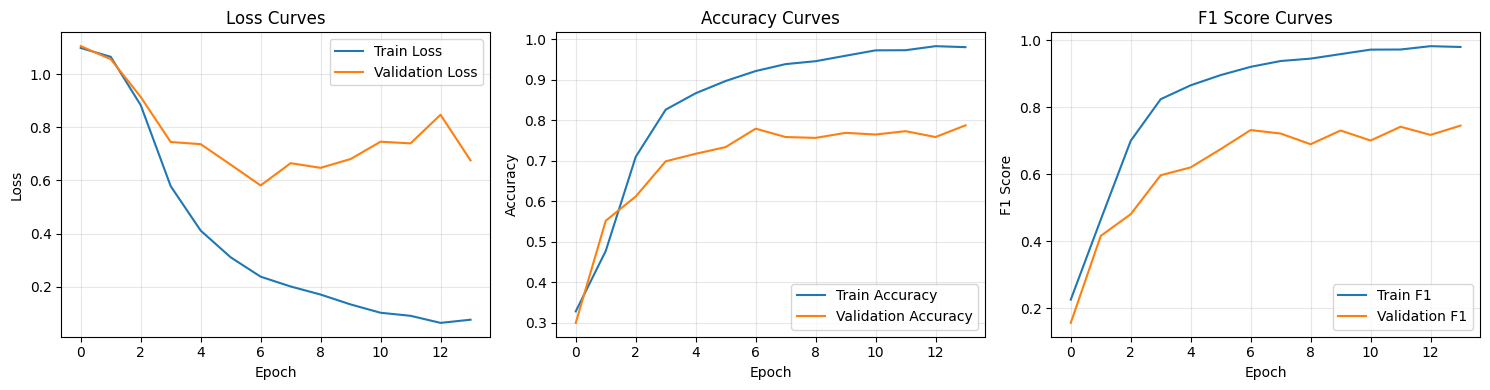

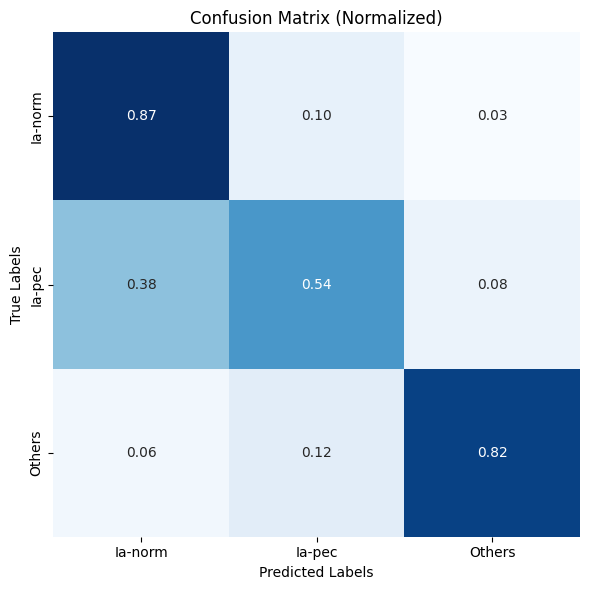

Loading augmented_images_v2.0_224x224...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.86it/s]


Epoch 1/200 | Train L/A/F1: 1.1041 0.3218 0.1945 | Val L/A/F1: 1.1028 0.3017 0.1545
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 2/200 | Train L/A/F1: 1.0761 0.4362 0.4064 | Val L/A/F1: 1.0683 0.5847 0.4471
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 3/200 | Train L/A/F1: 0.9038 0.7155 0.7101 | Val L/A/F1: 0.9025 0.6674 0.5154
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 4/200 | Train L/A/F1: 0.5817 0.8255 0.8235 | Val L/A/F1: 0.6514 0.7645 0.6711
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.91it/s]


Epoch 5/200 | Train L/A/F1: 0.3705 0.8794 0.8784 | Val L/A/F1: 0.5852 0.7624 0.7349
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 6/200 | Train L/A/F1: 0.2582 0.9169 0.9166 | Val L/A/F1: 0.6197 0.7769 0.7363
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 7/200 | Train L/A/F1: 0.1641 0.9501 0.9500 | Val L/A/F1: 0.6296 0.7934 0.7484
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 8/200 | Train L/A/F1: 0.1162 0.9676 0.9676 | Val L/A/F1: 0.7002 0.7727 0.7395
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 9/200 | Train L/A/F1: 0.0897 0.9739 0.9739 | Val L/A/F1: 1.0268 0.7417 0.6832
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.91it/s]


Epoch 10/200 | Train L/A/F1: 0.0553 0.9864 0.9863 | Val L/A/F1: 0.7440 0.7748 0.7453
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 11/200 | Train L/A/F1: 0.0365 0.9918 0.9918 | Val L/A/F1: 0.8222 0.7851 0.7491
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 12/200 | Train L/A/F1: 0.0268 0.9935 0.9935 | Val L/A/F1: 0.8624 0.7810 0.7537
Epoch 12 | LR = 1.00e-05
Early stopping after 12 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.9320    0.7901    0.8552       243
      Ia-pec     0.5000    0.7053    0.5852        95
      Others     0.8264    0.8151    0.8207       146

    accuracy                         0.7810       484
   macro avg     0.7528    0.7702    0.7537       484
weighted avg     0.8154    0.7810    0.7918       484



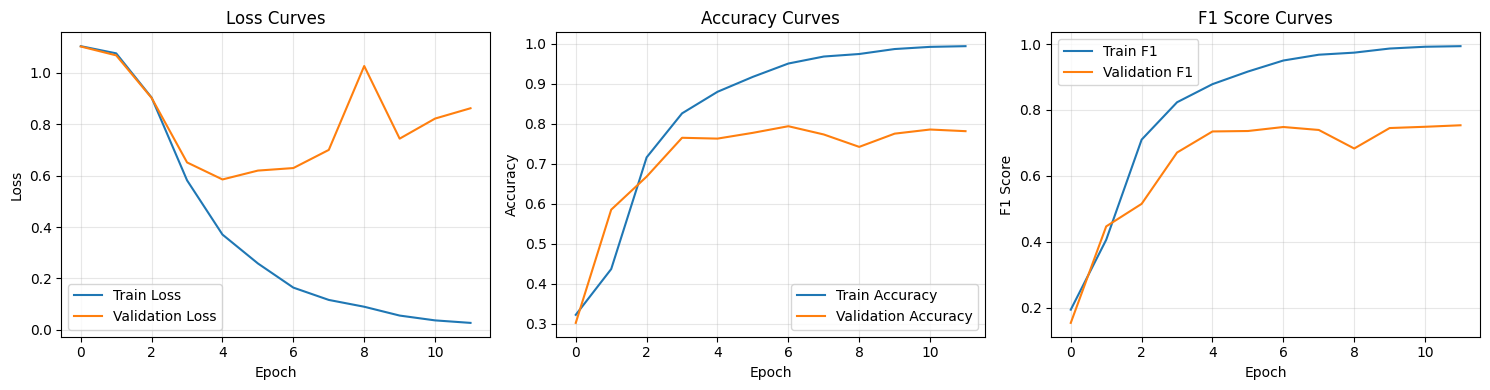

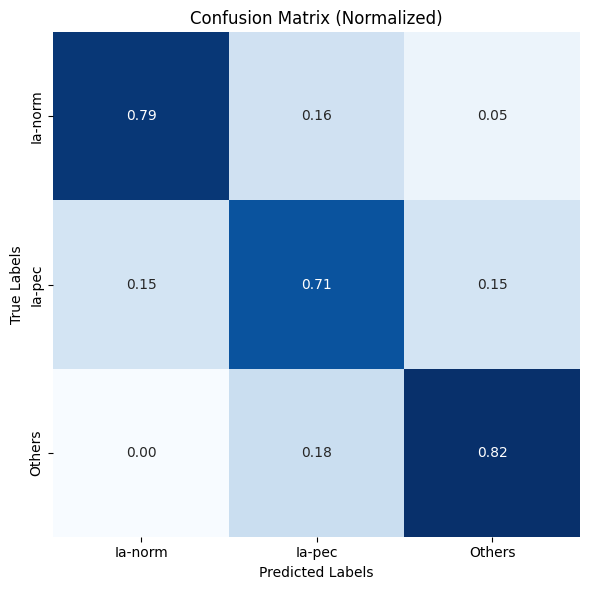

Loading augmented_images_v2.0_224x224...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.92it/s]


Epoch 1/200 | Train L/A/F1: 1.1037 0.3242 0.1967 | Val L/A/F1: 1.1051 0.3017 0.1545
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 2/200 | Train L/A/F1: 1.0765 0.4345 0.4070 | Val L/A/F1: 1.0653 0.6198 0.4847
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 3/200 | Train L/A/F1: 0.9129 0.7090 0.7033 | Val L/A/F1: 0.8746 0.7252 0.6207
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.99it/s]


Epoch 4/200 | Train L/A/F1: 0.6049 0.8145 0.8124 | Val L/A/F1: 0.6372 0.7810 0.7262
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 5/200 | Train L/A/F1: 0.3709 0.8796 0.8787 | Val L/A/F1: 0.5898 0.7955 0.7431
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 6/200 | Train L/A/F1: 0.2633 0.9137 0.9133 | Val L/A/F1: 0.6393 0.7810 0.7406
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 7/200 | Train L/A/F1: 0.1674 0.9468 0.9466 | Val L/A/F1: 0.6960 0.7727 0.7398
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 8/200 | Train L/A/F1: 0.1246 0.9633 0.9631 | Val L/A/F1: 0.6745 0.8182 0.7817
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 9/200 | Train L/A/F1: 0.0893 0.9753 0.9753 | Val L/A/F1: 0.6136 0.8347 0.8074
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 10/200 | Train L/A/F1: 0.0608 0.9846 0.9846 | Val L/A/F1: 0.9342 0.7872 0.7458
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 11/200 | Train L/A/F1: 0.0470 0.9881 0.9881 | Val L/A/F1: 0.8635 0.7955 0.7440
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 12/200 | Train L/A/F1: 0.0465 0.9867 0.9867 | Val L/A/F1: 0.7179 0.8161 0.7884
Epoch 12 | LR = 1.00e-05
Early stopping after 12 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.8816    0.8889    0.8852       243
      Ia-pec     0.6768    0.7053    0.6907        95
      Others     0.8643    0.8288    0.8462       146

    accuracy                         0.8347       484
   macro avg     0.8076    0.8076    0.8074       484
weighted avg     0.8362    0.8347    0.8353       484



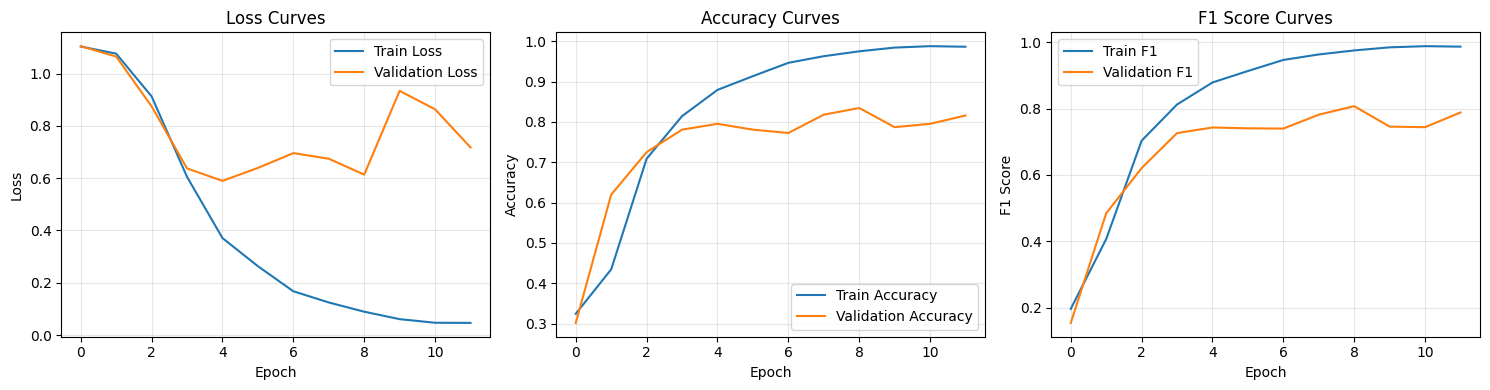

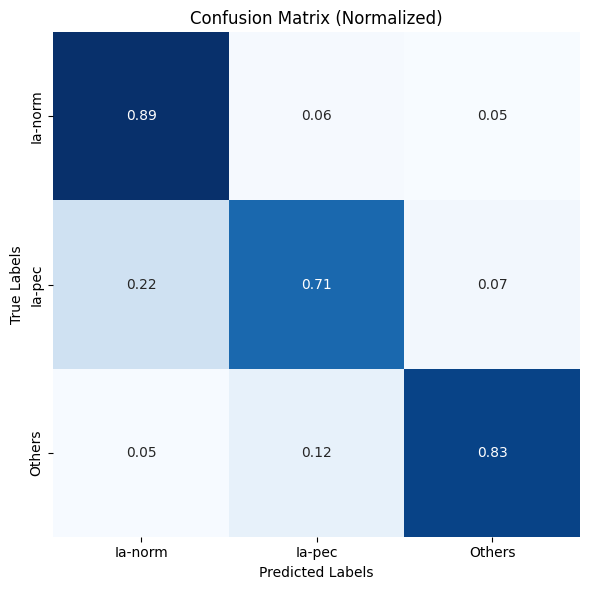

Loading augmented_images_v2.0_224x224...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.88it/s]


Epoch 1/200 | Train L/A/F1: 1.1035 0.3253 0.1957 | Val L/A/F1: 1.1076 0.3017 0.1608
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 2/200 | Train L/A/F1: 1.0756 0.4366 0.4065 | Val L/A/F1: 1.0710 0.5826 0.4395
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 3/200 | Train L/A/F1: 0.9031 0.7204 0.7165 | Val L/A/F1: 0.9097 0.6798 0.6003
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 4/200 | Train L/A/F1: 0.5933 0.8185 0.8162 | Val L/A/F1: 0.7111 0.7252 0.6651
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 5/200 | Train L/A/F1: 0.3969 0.8684 0.8674 | Val L/A/F1: 0.6245 0.7624 0.6921
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.92it/s]


Epoch 6/200 | Train L/A/F1: 0.2632 0.9151 0.9145 | Val L/A/F1: 0.6148 0.7748 0.7175
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 7/200 | Train L/A/F1: 0.1864 0.9381 0.9379 | Val L/A/F1: 0.5794 0.7686 0.7151
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 8/200 | Train L/A/F1: 0.1476 0.9529 0.9528 | Val L/A/F1: 0.7279 0.7417 0.6824
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.91it/s]


Epoch 9/200 | Train L/A/F1: 0.0832 0.9787 0.9786 | Val L/A/F1: 0.8767 0.7479 0.7282
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 10/200 | Train L/A/F1: 0.0522 0.9878 0.9877 | Val L/A/F1: 0.7348 0.7810 0.7411
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 11/200 | Train L/A/F1: 0.0447 0.9876 0.9876 | Val L/A/F1: 0.8151 0.7541 0.6940
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 12/200 | Train L/A/F1: 0.0488 0.9862 0.9862 | Val L/A/F1: 1.0889 0.7087 0.6656
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 13/200 | Train L/A/F1: 0.0376 0.9893 0.9893 | Val L/A/F1: 0.7333 0.7934 0.7608
Epoch 13 | LR = 1.00e-05


Epoch 14/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 14/200 | Train L/A/F1: 0.0160 0.9969 0.9969 | Val L/A/F1: 0.8724 0.7975 0.7676
Epoch 14 | LR = 1.00e-05
Early stopping after 14 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.8434    0.8642    0.8537       243
      Ia-pec     0.6058    0.6632    0.6332        95
      Others     0.8626    0.7740    0.8159       146

    accuracy                         0.7975       484
   macro avg     0.7706    0.7671    0.7676       484
weighted avg     0.8025    0.7975    0.7990       484



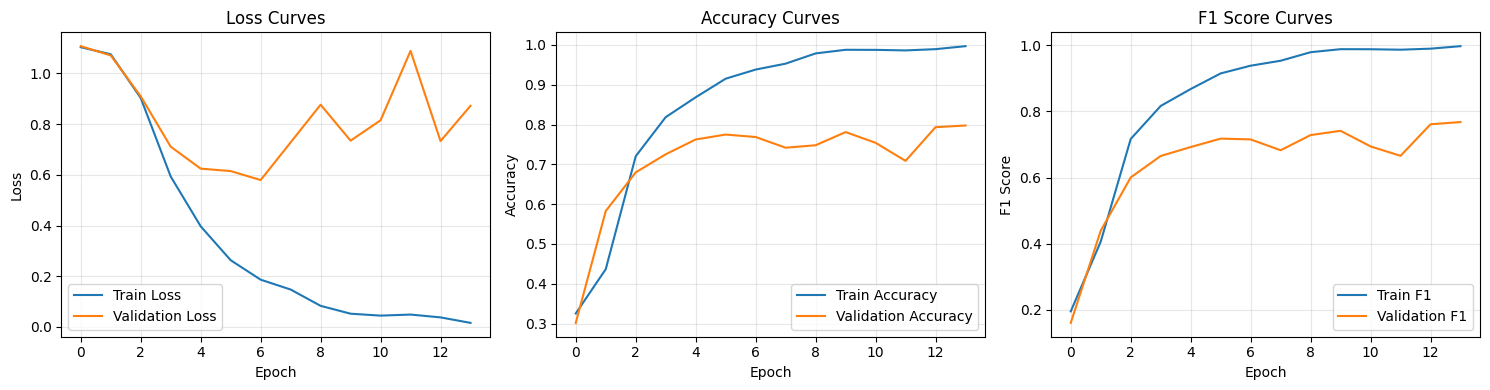

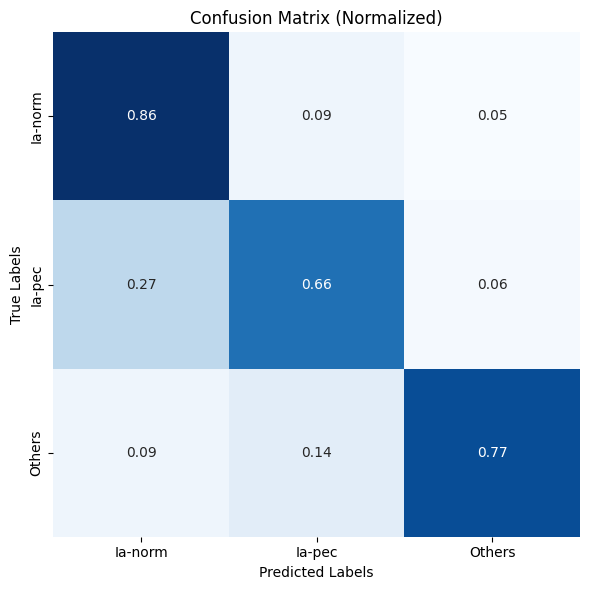

Loading augmented_images_v2.0_224x224_n...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.91it/s]


Epoch 1/200 | Train L/A/F1: 1.1009 0.3185 0.2108 | Val L/A/F1: 1.1063 0.3017 0.1545
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 2/200 | Train L/A/F1: 1.0728 0.4469 0.4307 | Val L/A/F1: 1.0650 0.5661 0.4518
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 3/200 | Train L/A/F1: 0.9106 0.6796 0.6707 | Val L/A/F1: 0.9370 0.6529 0.5889
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 4/200 | Train L/A/F1: 0.6601 0.7823 0.7810 | Val L/A/F1: 0.7741 0.6983 0.6263
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 5/200 | Train L/A/F1: 0.4829 0.8364 0.8356 | Val L/A/F1: 0.7680 0.7211 0.6326
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 6/200 | Train L/A/F1: 0.3705 0.8719 0.8714 | Val L/A/F1: 0.6083 0.7975 0.7491
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 7/200 | Train L/A/F1: 0.3047 0.8954 0.8950 | Val L/A/F1: 0.6105 0.8017 0.7394
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 8/200 | Train L/A/F1: 0.2625 0.9088 0.9086 | Val L/A/F1: 0.6479 0.7893 0.7495
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 9/200 | Train L/A/F1: 0.1972 0.9353 0.9352 | Val L/A/F1: 0.6331 0.8099 0.7791
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 10/200 | Train L/A/F1: 0.1736 0.9428 0.9427 | Val L/A/F1: 0.6717 0.7934 0.7541
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 11/200 | Train L/A/F1: 0.1389 0.9559 0.9559 | Val L/A/F1: 0.7448 0.8058 0.7644
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 12/200 | Train L/A/F1: 0.1010 0.9694 0.9694 | Val L/A/F1: 0.9528 0.7521 0.7141
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 13/200 | Train L/A/F1: 0.0854 0.9743 0.9743 | Val L/A/F1: 0.8499 0.7810 0.7531
Epoch 13 | LR = 1.00e-05
Early stopping after 13 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.8798    0.8436    0.8613       243
      Ia-pec     0.6354    0.6421    0.6387        95
      Others     0.8129    0.8630    0.8372       146

    accuracy                         0.8099       484
   macro avg     0.7760    0.7829    0.7791       484
weighted avg     0.8117    0.8099    0.8104       484



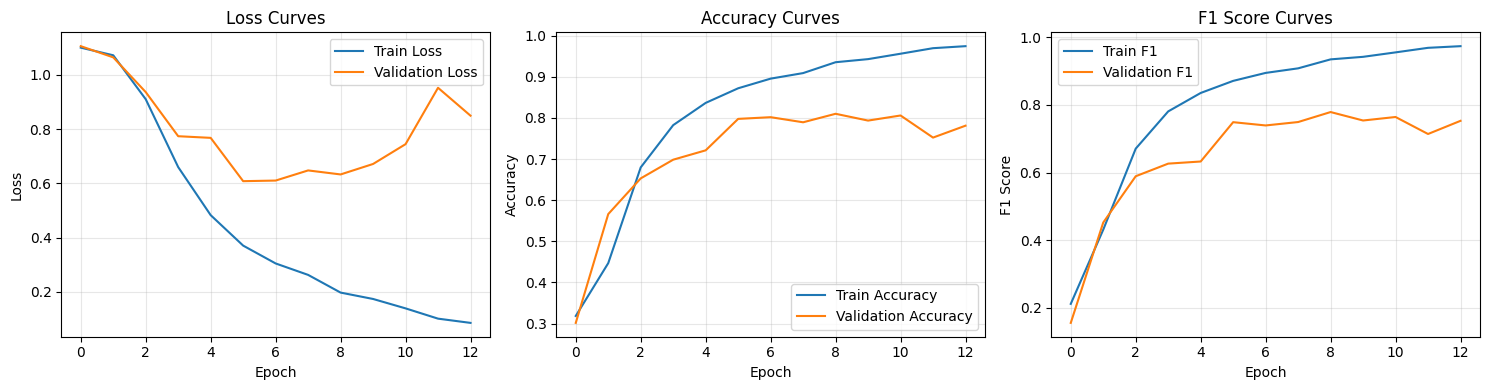

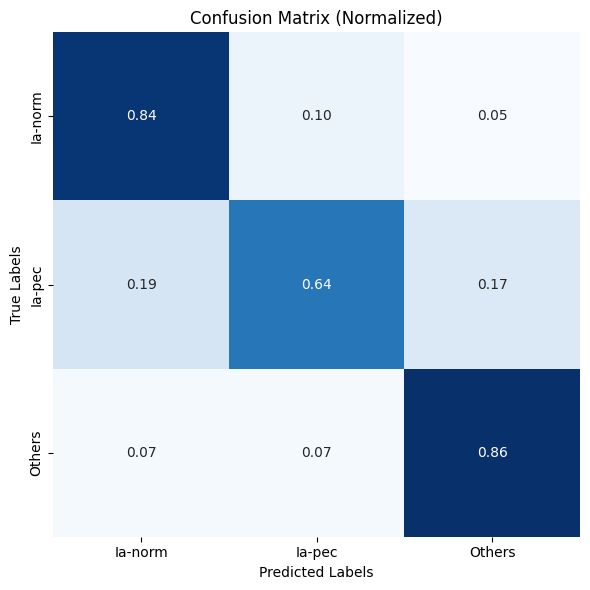

Loading augmented_images_v2.0_224x224_n...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.92it/s]


Epoch 1/200 | Train L/A/F1: 1.1006 0.3209 0.2123 | Val L/A/F1: 1.1059 0.2996 0.1537
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 2/200 | Train L/A/F1: 1.0721 0.4558 0.4426 | Val L/A/F1: 1.0522 0.5971 0.4657
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 3/200 | Train L/A/F1: 0.9140 0.6735 0.6644 | Val L/A/F1: 0.9120 0.6302 0.4969
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 4/200 | Train L/A/F1: 0.6466 0.7907 0.7897 | Val L/A/F1: 0.6853 0.7335 0.6680
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 5/200 | Train L/A/F1: 0.4658 0.8439 0.8435 | Val L/A/F1: 0.6477 0.7583 0.6593
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 6/200 | Train L/A/F1: 0.3692 0.8698 0.8691 | Val L/A/F1: 0.6032 0.7872 0.7309
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 7/200 | Train L/A/F1: 0.2843 0.9036 0.9033 | Val L/A/F1: 0.6349 0.7913 0.7464
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 8/200 | Train L/A/F1: 0.2418 0.9179 0.9178 | Val L/A/F1: 0.5703 0.8017 0.7552
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 9/200 | Train L/A/F1: 0.2183 0.9256 0.9254 | Val L/A/F1: 0.6177 0.8058 0.7419
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 10/200 | Train L/A/F1: 0.1515 0.9529 0.9528 | Val L/A/F1: 0.6593 0.8017 0.7382
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.92it/s]


Epoch 11/200 | Train L/A/F1: 0.1317 0.9571 0.9571 | Val L/A/F1: 0.6795 0.7934 0.7561
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.92it/s]


Epoch 12/200 | Train L/A/F1: 0.1028 0.9703 0.9702 | Val L/A/F1: 0.7222 0.7996 0.7696
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 13/200 | Train L/A/F1: 0.1096 0.9643 0.9643 | Val L/A/F1: 0.6592 0.7913 0.7552
Epoch 13 | LR = 1.00e-05


Epoch 14/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 14/200 | Train L/A/F1: 0.0650 0.9832 0.9832 | Val L/A/F1: 0.7409 0.8099 0.7750
Epoch 14 | LR = 1.00e-05


Epoch 15/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 15/200 | Train L/A/F1: 0.0730 0.9760 0.9760 | Val L/A/F1: 0.7489 0.8161 0.7640
Epoch 15 | LR = 1.00e-05
Early stopping after 15 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.8327    0.9012    0.8656       243
      Ia-pec     0.5784    0.6211    0.5990        95
      Others     0.9580    0.7808    0.8604       146

    accuracy                         0.8099       484
   macro avg     0.7897    0.7677    0.7750       484
weighted avg     0.8206    0.8099    0.8117       484



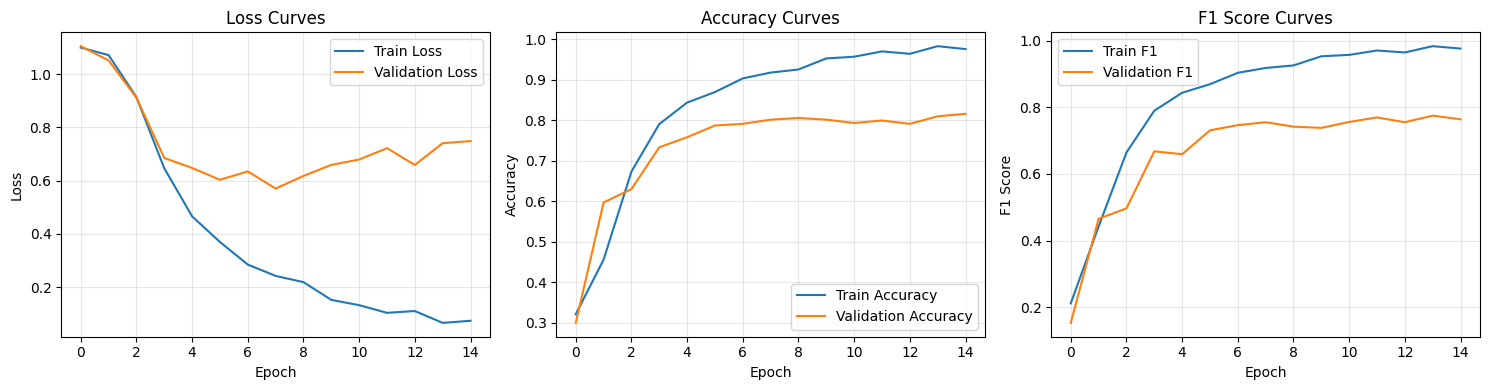

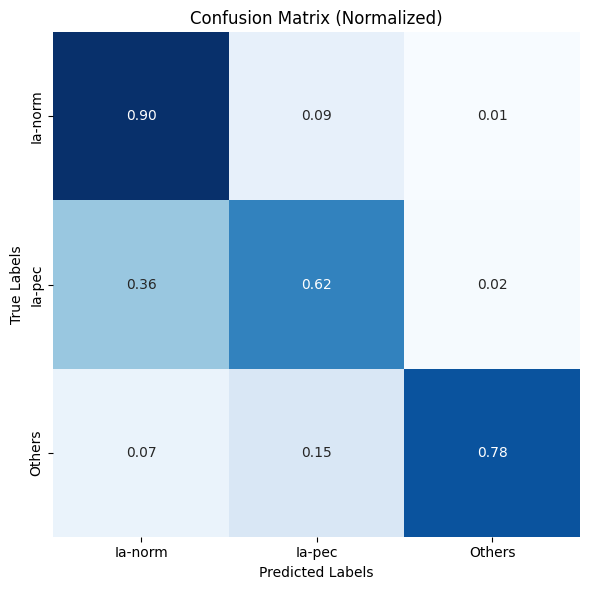

Loading augmented_images_v2.0_224x224_n...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.92it/s]


Epoch 1/200 | Train L/A/F1: 1.1007 0.3235 0.2156 | Val L/A/F1: 1.1061 0.3017 0.1547
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 2/200 | Train L/A/F1: 1.0723 0.4523 0.4383 | Val L/A/F1: 1.0613 0.5558 0.4214
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 3/200 | Train L/A/F1: 0.9140 0.6766 0.6672 | Val L/A/F1: 0.9225 0.6405 0.5749
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 4/200 | Train L/A/F1: 0.6411 0.7955 0.7943 | Val L/A/F1: 0.8484 0.6550 0.5840
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 5/200 | Train L/A/F1: 0.4606 0.8460 0.8453 | Val L/A/F1: 0.7403 0.7066 0.6349
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 6/200 | Train L/A/F1: 0.3601 0.8803 0.8798 | Val L/A/F1: 0.8366 0.6942 0.6115
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 7/200 | Train L/A/F1: 0.2876 0.9071 0.9068 | Val L/A/F1: 0.8429 0.6839 0.6096
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.99it/s]


Epoch 8/200 | Train L/A/F1: 0.2394 0.9209 0.9207 | Val L/A/F1: 0.7792 0.7252 0.6808
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 9/200 | Train L/A/F1: 0.1978 0.9372 0.9371 | Val L/A/F1: 0.7127 0.7314 0.6595
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 10/200 | Train L/A/F1: 0.1528 0.9529 0.9528 | Val L/A/F1: 0.8690 0.6880 0.6577
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 11/200 | Train L/A/F1: 0.1407 0.9545 0.9545 | Val L/A/F1: 0.8597 0.7211 0.6810
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 12/200 | Train L/A/F1: 0.1047 0.9697 0.9697 | Val L/A/F1: 0.9134 0.7190 0.6654
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 13/200 | Train L/A/F1: 0.0889 0.9750 0.9750 | Val L/A/F1: 0.7937 0.7769 0.7189
Epoch 13 | LR = 1.00e-05


Epoch 14/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 14/200 | Train L/A/F1: 0.0731 0.9788 0.9788 | Val L/A/F1: 1.0730 0.7169 0.6797
Epoch 14 | LR = 1.00e-05


Epoch 15/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 15/200 | Train L/A/F1: 0.0636 0.9813 0.9813 | Val L/A/F1: 0.9190 0.7562 0.6953
Epoch 15 | LR = 1.00e-05


Epoch 16/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 16/200 | Train L/A/F1: 0.0521 0.9853 0.9853 | Val L/A/F1: 1.0477 0.7335 0.6866
Epoch 16 | LR = 1.00e-05
Early stopping after 16 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.7799    0.8601    0.8180       243
      Ia-pec     0.6271    0.3895    0.4805        95
      Others     0.8280    0.8904    0.8581       146

    accuracy                         0.7769       484
   macro avg     0.7450    0.7133    0.7189       484
weighted avg     0.7644    0.7769    0.7639       484



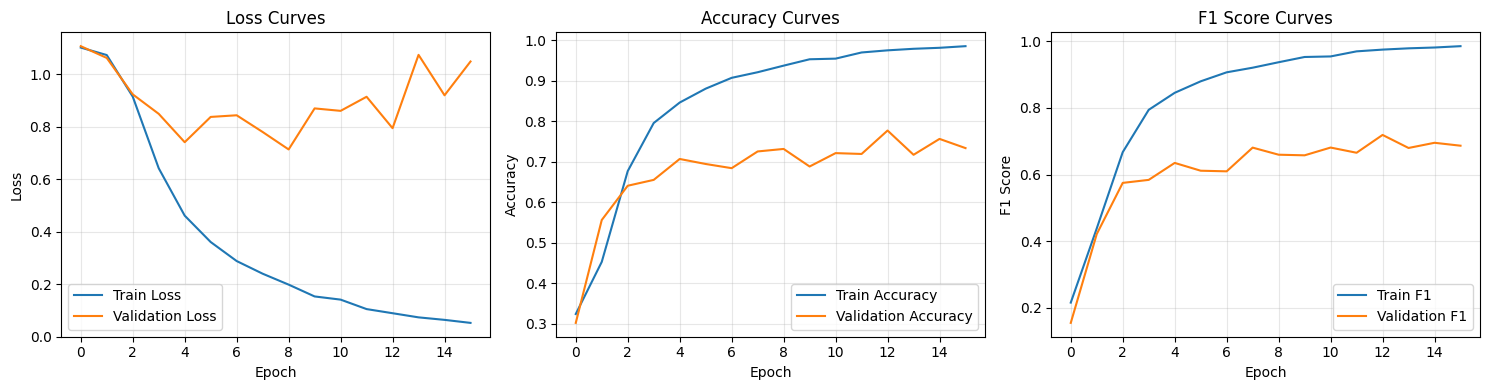

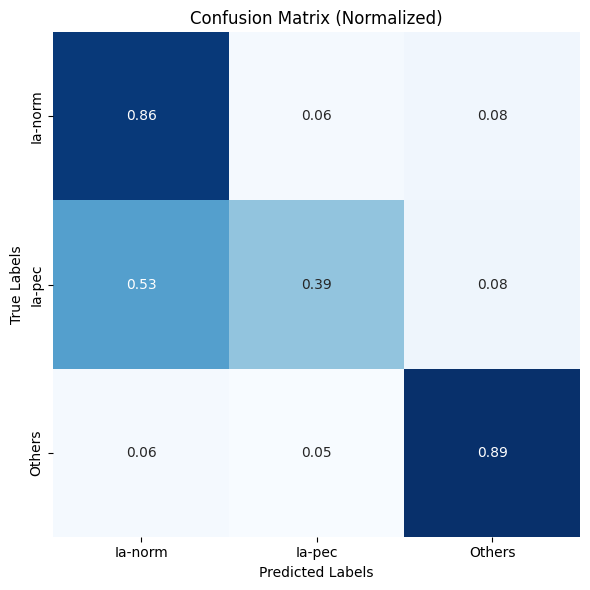

Loading augmented_images_v2.0_224x56...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.91it/s]


Epoch 1/200 | Train L/A/F1: 1.1048 0.3179 0.2107 | Val L/A/F1: 1.1114 0.2913 0.1504
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.99it/s]


Epoch 2/200 | Train L/A/F1: 1.0807 0.4189 0.3856 | Val L/A/F1: 1.0736 0.6116 0.4898
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 3/200 | Train L/A/F1: 0.9119 0.7050 0.6960 | Val L/A/F1: 0.8783 0.6736 0.5617
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 4/200 | Train L/A/F1: 0.5874 0.8201 0.8169 | Val L/A/F1: 0.6580 0.7562 0.6305
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 5/200 | Train L/A/F1: 0.3566 0.8838 0.8829 | Val L/A/F1: 0.5699 0.8079 0.7261
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.91it/s]


Epoch 6/200 | Train L/A/F1: 0.2368 0.9241 0.9237 | Val L/A/F1: 0.6782 0.7934 0.7572
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 7/200 | Train L/A/F1: 0.1538 0.9522 0.9521 | Val L/A/F1: 0.8532 0.7624 0.7419
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.92it/s]


Epoch 8/200 | Train L/A/F1: 0.1073 0.9725 0.9725 | Val L/A/F1: 0.7261 0.8120 0.7682
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 9/200 | Train L/A/F1: 0.0861 0.9762 0.9762 | Val L/A/F1: 0.7587 0.8099 0.7624
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 10/200 | Train L/A/F1: 0.0574 0.9864 0.9863 | Val L/A/F1: 0.7617 0.8182 0.7654
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 11/200 | Train L/A/F1: 0.0423 0.9914 0.9914 | Val L/A/F1: 1.2447 0.7087 0.6992
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 12/200 | Train L/A/F1: 0.0585 0.9841 0.9841 | Val L/A/F1: 0.8820 0.8037 0.7585
Epoch 12 | LR = 1.00e-05
Early stopping after 12 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.8992    0.8807    0.8898       243
      Ia-pec     0.5978    0.5789    0.5882        95
      Others     0.8052    0.8493    0.8267       146

    accuracy                         0.8120       484
   macro avg     0.7674    0.7696    0.7682       484
weighted avg     0.8117    0.8120    0.8116       484



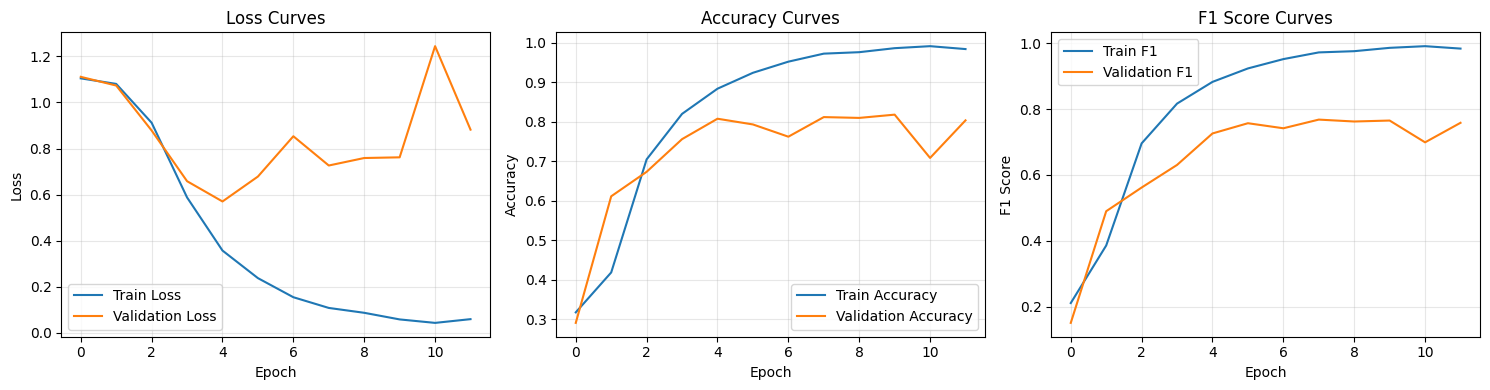

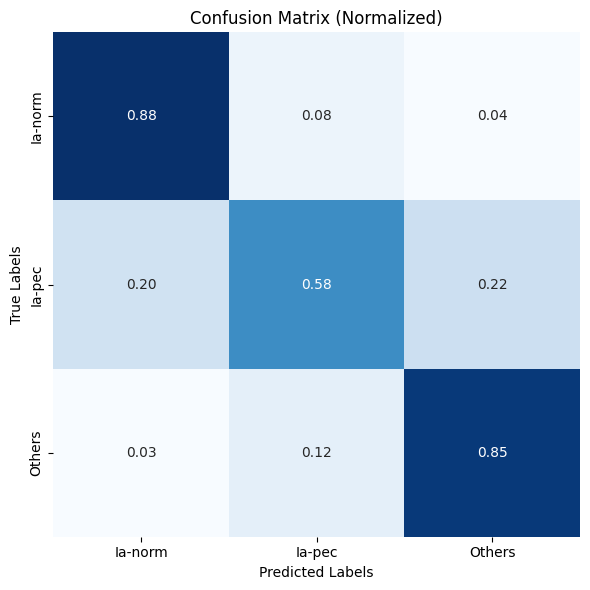

Loading augmented_images_v2.0_224x56...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.89it/s]


Epoch 1/200 | Train L/A/F1: 1.1049 0.3179 0.2122 | Val L/A/F1: 1.1126 0.2996 0.1537
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.99it/s]


Epoch 2/200 | Train L/A/F1: 1.0802 0.4231 0.3912 | Val L/A/F1: 1.0695 0.6405 0.5529
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 3/200 | Train L/A/F1: 0.9133 0.7004 0.6880 | Val L/A/F1: 0.8989 0.6818 0.5849
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.99it/s]


Epoch 4/200 | Train L/A/F1: 0.5750 0.8310 0.8280 | Val L/A/F1: 0.6305 0.7624 0.6695
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 5/200 | Train L/A/F1: 0.3484 0.8896 0.8887 | Val L/A/F1: 0.5577 0.7707 0.6774
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 6/200 | Train L/A/F1: 0.2350 0.9253 0.9249 | Val L/A/F1: 0.6490 0.7769 0.7206
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 7/200 | Train L/A/F1: 0.1754 0.9452 0.9451 | Val L/A/F1: 0.7064 0.7727 0.7366
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 8/200 | Train L/A/F1: 0.1125 0.9713 0.9712 | Val L/A/F1: 0.5817 0.8285 0.7979
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 9/200 | Train L/A/F1: 0.0819 0.9774 0.9774 | Val L/A/F1: 0.7052 0.7955 0.7555
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.90it/s]


Epoch 10/200 | Train L/A/F1: 0.0565 0.9879 0.9879 | Val L/A/F1: 1.0177 0.7541 0.7195
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 11/200 | Train L/A/F1: 0.0559 0.9855 0.9855 | Val L/A/F1: 0.7061 0.8347 0.8032
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 12/200 | Train L/A/F1: 0.0430 0.9895 0.9895 | Val L/A/F1: 0.6972 0.8285 0.7964
Epoch 12 | LR = 1.00e-05
Early stopping after 12 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.8517    0.9218    0.8854       243
      Ia-pec     0.7126    0.6526    0.6813        95
      Others     0.8806    0.8082    0.8429       146

    accuracy                         0.8347       484
   macro avg     0.8150    0.7942    0.8032       484
weighted avg     0.8331    0.8347    0.8325       484



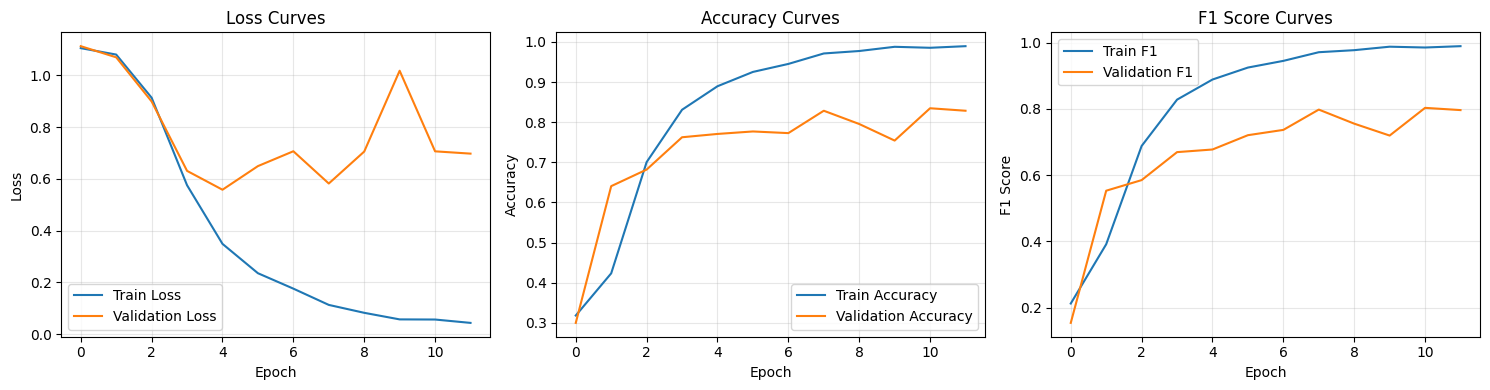

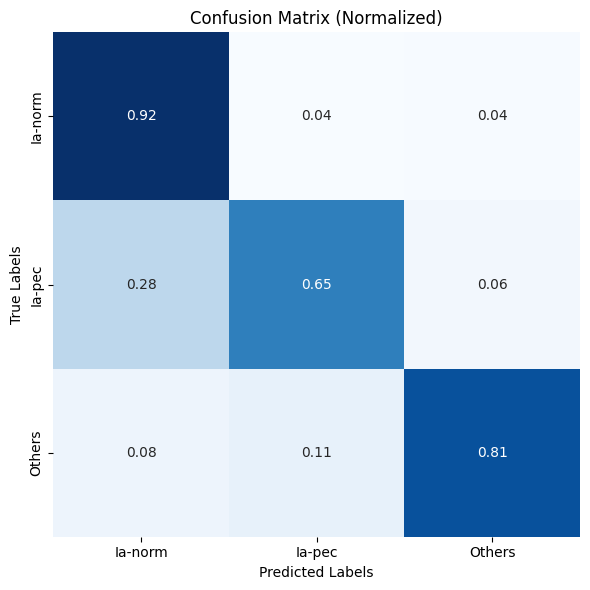

Loading augmented_images_v2.0_224x56...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 1/200 | Train L/A/F1: 1.1047 0.3197 0.2123 | Val L/A/F1: 1.1132 0.2934 0.1512
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 2/200 | Train L/A/F1: 1.0802 0.4178 0.3844 | Val L/A/F1: 1.0712 0.6240 0.5165
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 3/200 | Train L/A/F1: 0.9075 0.7132 0.7019 | Val L/A/F1: 0.8877 0.6818 0.5960
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 4/200 | Train L/A/F1: 0.5575 0.8374 0.8348 | Val L/A/F1: 0.6622 0.7541 0.6838
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 5/200 | Train L/A/F1: 0.3634 0.8845 0.8836 | Val L/A/F1: 0.6450 0.7727 0.6864
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 6/200 | Train L/A/F1: 0.2330 0.9300 0.9298 | Val L/A/F1: 0.6002 0.7872 0.7242
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 7/200 | Train L/A/F1: 0.1642 0.9533 0.9532 | Val L/A/F1: 0.6020 0.7831 0.7300
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 8/200 | Train L/A/F1: 0.1288 0.9641 0.9640 | Val L/A/F1: 0.9074 0.7273 0.6635
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 9/200 | Train L/A/F1: 0.0979 0.9748 0.9748 | Val L/A/F1: 0.6623 0.7851 0.7250
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 10/200 | Train L/A/F1: 0.0783 0.9811 0.9811 | Val L/A/F1: 0.7234 0.7727 0.7392
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 11/200 | Train L/A/F1: 0.0564 0.9878 0.9877 | Val L/A/F1: 0.8986 0.7562 0.7178
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 12/200 | Train L/A/F1: 0.0459 0.9911 0.9911 | Val L/A/F1: 0.7057 0.8120 0.7742
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 13/200 | Train L/A/F1: 0.0526 0.9850 0.9849 | Val L/A/F1: 1.0635 0.7335 0.6601
Epoch 13 | LR = 1.00e-05
Early stopping after 13 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.8571    0.8395    0.8482       243
      Ia-pec     0.6092    0.5579    0.5824        95
      Others     0.8553    0.9315    0.8918       146

    accuracy                         0.8120       484
   macro avg     0.7739    0.7763    0.7742       484
weighted avg     0.8079    0.8120    0.8092       484



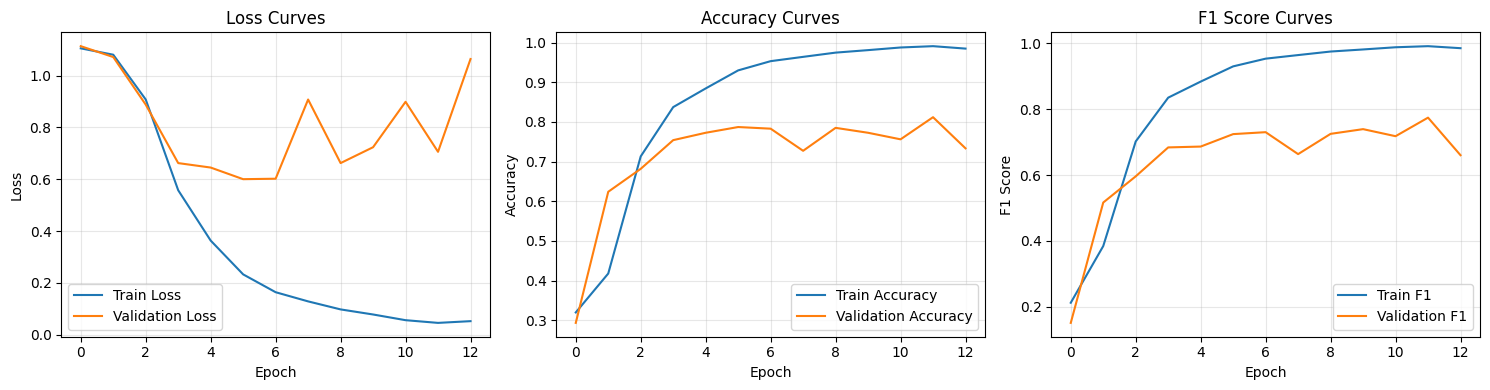

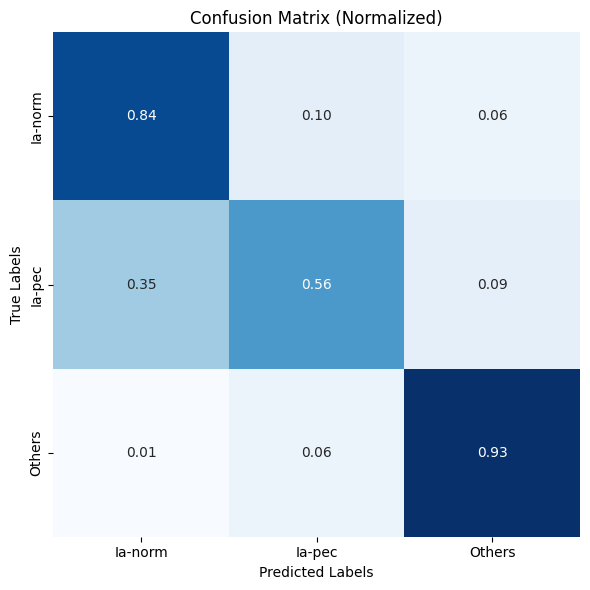

Loading augmented_images_v2.0_224x56_n...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 1/200 | Train L/A/F1: 1.0969 0.3248 0.2412 | Val L/A/F1: 1.1058 0.2955 0.1592
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.99it/s]


Epoch 2/200 | Train L/A/F1: 1.0619 0.4773 0.4623 | Val L/A/F1: 1.0474 0.6012 0.4778
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 3/200 | Train L/A/F1: 0.8742 0.7017 0.6867 | Val L/A/F1: 0.8276 0.6901 0.5990
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 4/200 | Train L/A/F1: 0.5989 0.8096 0.8071 | Val L/A/F1: 0.7338 0.7211 0.6098
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 5/200 | Train L/A/F1: 0.4193 0.8618 0.8607 | Val L/A/F1: 0.6737 0.7500 0.6454
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 6/200 | Train L/A/F1: 0.3163 0.8948 0.8940 | Val L/A/F1: 0.5175 0.8120 0.7565
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 7/200 | Train L/A/F1: 0.2357 0.9237 0.9234 | Val L/A/F1: 0.4561 0.8223 0.7825
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 8/200 | Train L/A/F1: 0.1954 0.9356 0.9354 | Val L/A/F1: 0.6738 0.7707 0.7192
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 9/200 | Train L/A/F1: 0.1579 0.9472 0.9471 | Val L/A/F1: 0.5062 0.8244 0.7874
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 10/200 | Train L/A/F1: 0.1206 0.9638 0.9637 | Val L/A/F1: 0.4810 0.8306 0.7909
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 11/200 | Train L/A/F1: 0.0889 0.9752 0.9751 | Val L/A/F1: 0.5673 0.8264 0.7972
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 12/200 | Train L/A/F1: 0.0563 0.9874 0.9874 | Val L/A/F1: 0.5993 0.8430 0.8203
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 13/200 | Train L/A/F1: 0.0584 0.9851 0.9851 | Val L/A/F1: 0.7255 0.7955 0.7463
Epoch 13 | LR = 1.00e-05


Epoch 14/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 14/200 | Train L/A/F1: 0.0653 0.9809 0.9809 | Val L/A/F1: 0.7545 0.8017 0.7624
Epoch 14 | LR = 1.00e-05
Early stopping after 14 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.9493    0.8477    0.8957       243
      Ia-pec     0.6356    0.7895    0.7042        95
      Others     0.8523    0.8699    0.8610       146

    accuracy                         0.8430       484
   macro avg     0.8124    0.8357    0.8203       484
weighted avg     0.8585    0.8430    0.8476       484



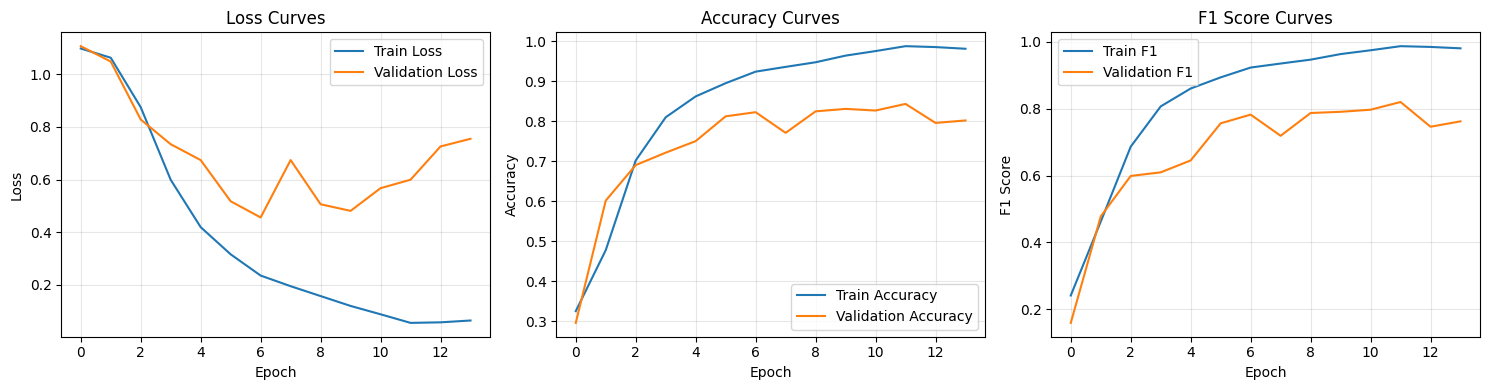

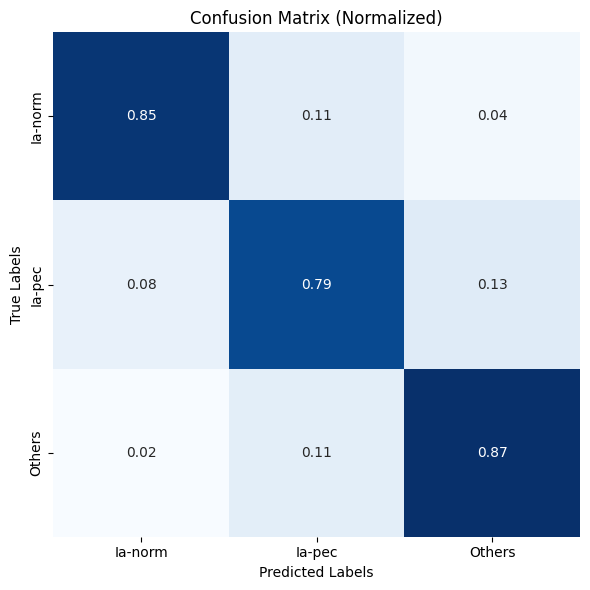

Loading augmented_images_v2.0_224x56_n...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 1/200 | Train L/A/F1: 1.0968 0.3255 0.2387 | Val L/A/F1: 1.1049 0.2955 0.1594
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 2/200 | Train L/A/F1: 1.0629 0.4709 0.4551 | Val L/A/F1: 1.0376 0.6116 0.4825
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 3/200 | Train L/A/F1: 0.8830 0.6903 0.6725 | Val L/A/F1: 0.8272 0.6715 0.5392
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 4/200 | Train L/A/F1: 0.6029 0.8112 0.8083 | Val L/A/F1: 0.6337 0.7603 0.7058
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 5/200 | Train L/A/F1: 0.4112 0.8635 0.8625 | Val L/A/F1: 0.4987 0.7934 0.7065
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 6/200 | Train L/A/F1: 0.3098 0.8971 0.8964 | Val L/A/F1: 0.5136 0.8058 0.7484
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.92it/s]


Epoch 7/200 | Train L/A/F1: 0.2356 0.9213 0.9209 | Val L/A/F1: 0.6788 0.7645 0.7238
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 8/200 | Train L/A/F1: 0.1959 0.9382 0.9380 | Val L/A/F1: 0.4493 0.8244 0.7721
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 9/200 | Train L/A/F1: 0.1647 0.9445 0.9444 | Val L/A/F1: 0.5133 0.8079 0.7587
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 10/200 | Train L/A/F1: 0.1256 0.9617 0.9616 | Val L/A/F1: 0.4509 0.8430 0.8041
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 11/200 | Train L/A/F1: 0.0893 0.9752 0.9751 | Val L/A/F1: 0.5453 0.8223 0.7923
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 12/200 | Train L/A/F1: 0.0773 0.9774 0.9774 | Val L/A/F1: 0.6244 0.8161 0.7915
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 13/200 | Train L/A/F1: 0.0635 0.9802 0.9802 | Val L/A/F1: 0.5414 0.8285 0.7992
Epoch 13 | LR = 1.00e-05


Epoch 14/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 14/200 | Train L/A/F1: 0.0559 0.9839 0.9839 | Val L/A/F1: 0.6166 0.8120 0.7909
Epoch 14 | LR = 1.00e-05


Epoch 15/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 15/200 | Train L/A/F1: 0.0332 0.9914 0.9914 | Val L/A/F1: 0.6951 0.8223 0.7891
Epoch 15 | LR = 1.00e-05
Early stopping after 15 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.8621    0.9259    0.8929       243
      Ia-pec     0.7089    0.5895    0.6437        95
      Others     0.8819    0.8699    0.8759       146

    accuracy                         0.8430       484
   macro avg     0.8176    0.7951    0.8041       484
weighted avg     0.8380    0.8430    0.8388       484



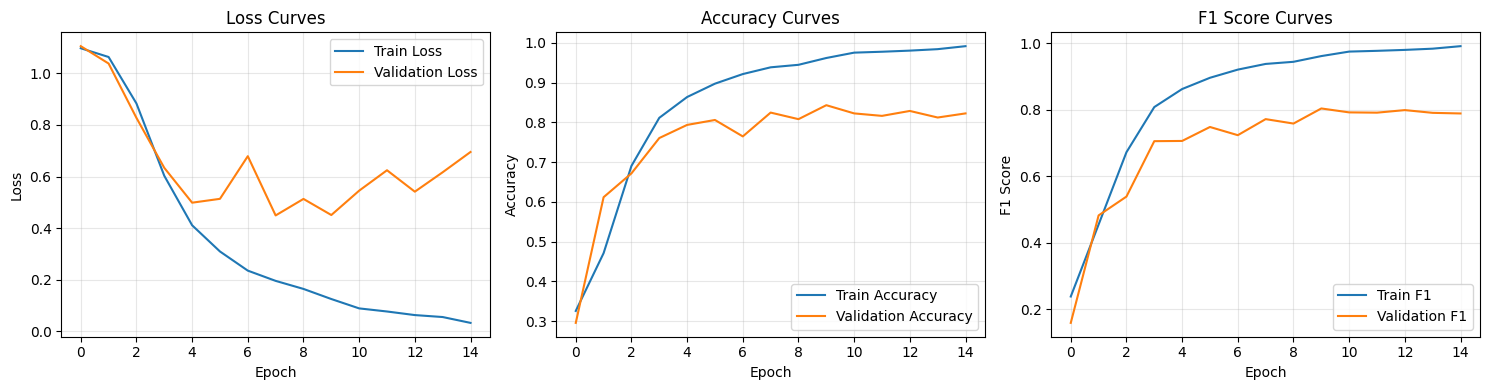

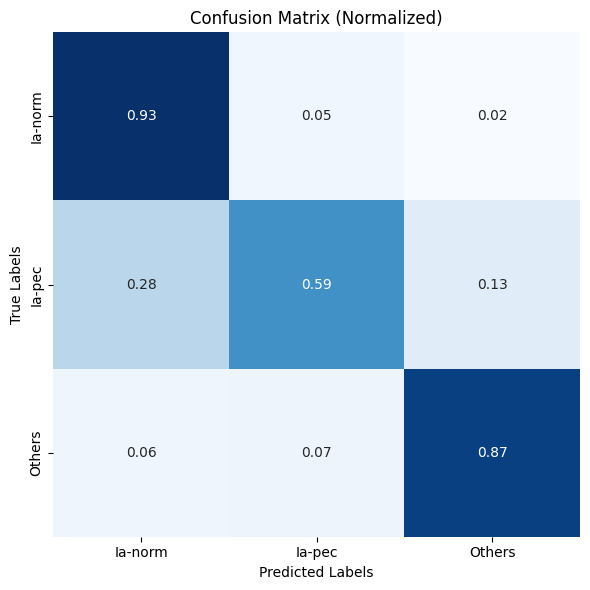

Loading augmented_images_v2.0_224x56_n...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 1/200 | Train L/A/F1: 1.0967 0.3249 0.2392 | Val L/A/F1: 1.1049 0.2996 0.1777
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 2/200 | Train L/A/F1: 1.0615 0.4759 0.4611 | Val L/A/F1: 1.0505 0.5764 0.4494
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 3/200 | Train L/A/F1: 0.8708 0.7122 0.6988 | Val L/A/F1: 0.8825 0.6302 0.5362
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 4/200 | Train L/A/F1: 0.5765 0.8210 0.8184 | Val L/A/F1: 0.7070 0.7004 0.6016
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 5/200 | Train L/A/F1: 0.3922 0.8728 0.8719 | Val L/A/F1: 0.6658 0.7355 0.6458
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 6/200 | Train L/A/F1: 0.2984 0.9018 0.9010 | Val L/A/F1: 0.7036 0.7231 0.6768
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 7/200 | Train L/A/F1: 0.2255 0.9277 0.9275 | Val L/A/F1: 0.7149 0.7479 0.7074
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 8/200 | Train L/A/F1: 0.1841 0.9410 0.9408 | Val L/A/F1: 0.6571 0.7624 0.7101
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.92it/s]


Epoch 9/200 | Train L/A/F1: 0.1601 0.9465 0.9464 | Val L/A/F1: 0.7079 0.7665 0.7150
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 10/200 | Train L/A/F1: 0.1121 0.9652 0.9651 | Val L/A/F1: 0.6579 0.7624 0.7331
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 11/200 | Train L/A/F1: 0.0905 0.9736 0.9736 | Val L/A/F1: 0.7193 0.7397 0.7082
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 12/200 | Train L/A/F1: 0.0653 0.9825 0.9825 | Val L/A/F1: 0.7328 0.7810 0.7315
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 13/200 | Train L/A/F1: 0.0498 0.9869 0.9869 | Val L/A/F1: 0.7091 0.7727 0.7323
Epoch 13 | LR = 1.00e-05


Epoch 14/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 14/200 | Train L/A/F1: 0.0383 0.9897 0.9897 | Val L/A/F1: 0.7913 0.7541 0.7257
Epoch 14 | LR = 1.00e-05


Epoch 15/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 15/200 | Train L/A/F1: 0.0350 0.9911 0.9911 | Val L/A/F1: 0.8594 0.7789 0.7381
Epoch 15 | LR = 1.00e-05
Early stopping after 15 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.8106    0.8807    0.8442       243
      Ia-pec     0.5408    0.5579    0.5492        95
      Others     0.9016    0.7534    0.8209       146

    accuracy                         0.7789       484
   macro avg     0.7510    0.7307    0.7381       484
weighted avg     0.7851    0.7789    0.7793       484



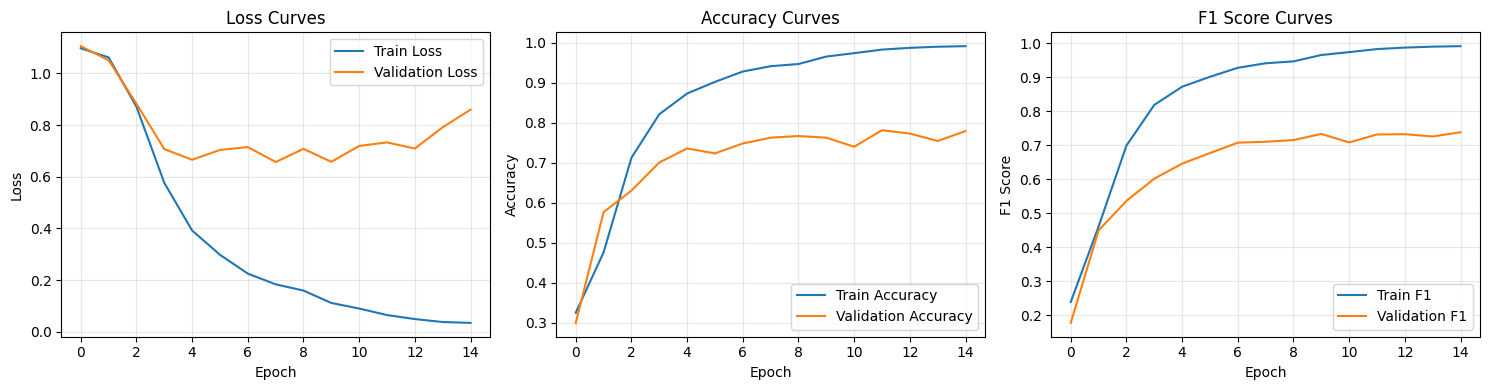

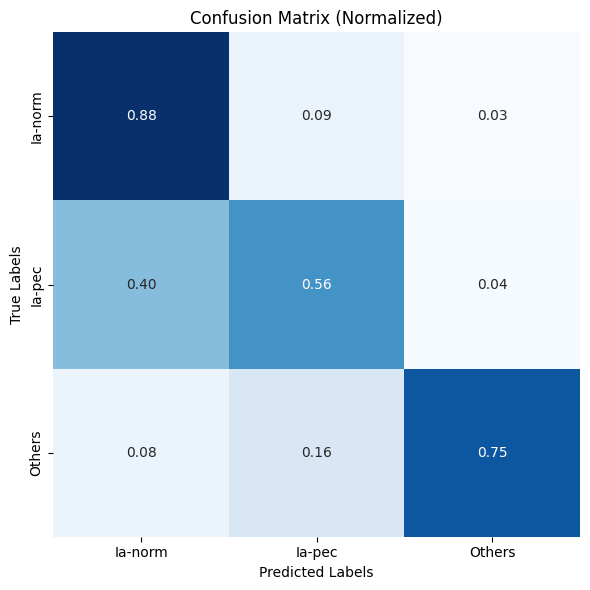

Loading augmented_images_v2.0_50x50...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 1/200 | Train L/A/F1: 1.1024 0.3340 0.2663 | Val L/A/F1: 1.1185 0.2541 0.2215
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 2/200 | Train L/A/F1: 1.0784 0.4408 0.4173 | Val L/A/F1: 1.0768 0.5682 0.5020
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 3/200 | Train L/A/F1: 0.9069 0.6843 0.6736 | Val L/A/F1: 0.8507 0.6942 0.5866
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 4/200 | Train L/A/F1: 0.6155 0.8052 0.8008 | Val L/A/F1: 0.6399 0.7624 0.6937
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.89it/s]


Epoch 5/200 | Train L/A/F1: 0.3894 0.8700 0.8687 | Val L/A/F1: 0.5784 0.7707 0.7063
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 6/200 | Train L/A/F1: 0.2745 0.9104 0.9099 | Val L/A/F1: 0.5098 0.8120 0.7689
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 7/200 | Train L/A/F1: 0.1843 0.9423 0.9421 | Val L/A/F1: 0.5900 0.7810 0.7437
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.61it/s]


Epoch 8/200 | Train L/A/F1: 0.1394 0.9585 0.9585 | Val L/A/F1: 0.5297 0.8161 0.7744
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 9/200 | Train L/A/F1: 0.0935 0.9750 0.9749 | Val L/A/F1: 0.8641 0.7831 0.7489
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.92it/s]


Epoch 10/200 | Train L/A/F1: 0.0749 0.9802 0.9802 | Val L/A/F1: 0.5520 0.8306 0.7757
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 11/200 | Train L/A/F1: 0.0555 0.9860 0.9860 | Val L/A/F1: 0.5694 0.8140 0.7725
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 12/200 | Train L/A/F1: 0.0318 0.9932 0.9932 | Val L/A/F1: 0.7513 0.8079 0.7716
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 13/200 | Train L/A/F1: 0.0320 0.9920 0.9919 | Val L/A/F1: 0.8736 0.7996 0.7537
Epoch 13 | LR = 1.00e-05
Early stopping after 13 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.8984    0.9095    0.9039       243
      Ia-pec     0.6714    0.4947    0.5697        95
      Others     0.7976    0.9178    0.8535       146

    accuracy                         0.8306       484
   macro avg     0.7891    0.7740    0.7757       484
weighted avg     0.8234    0.8306    0.8231       484



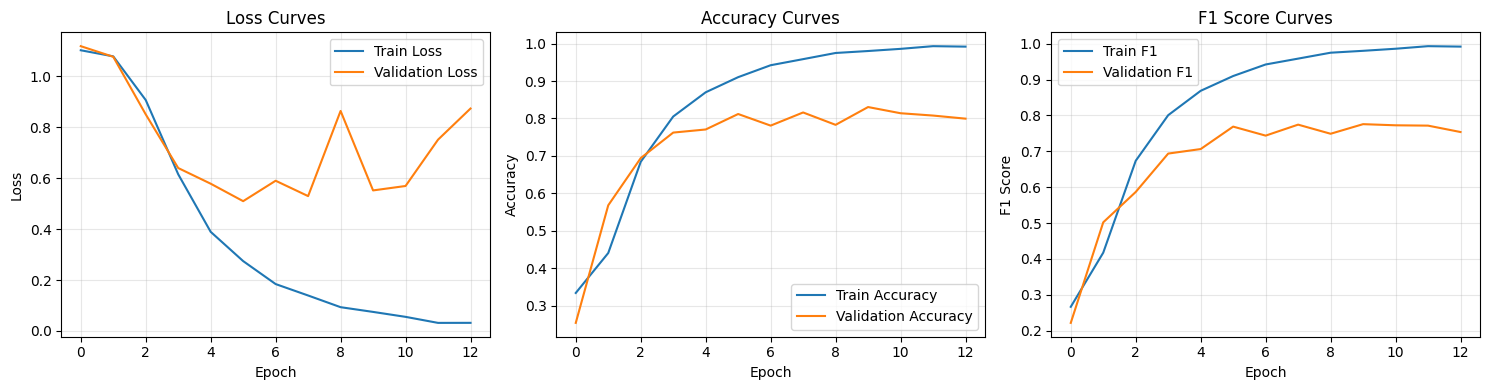

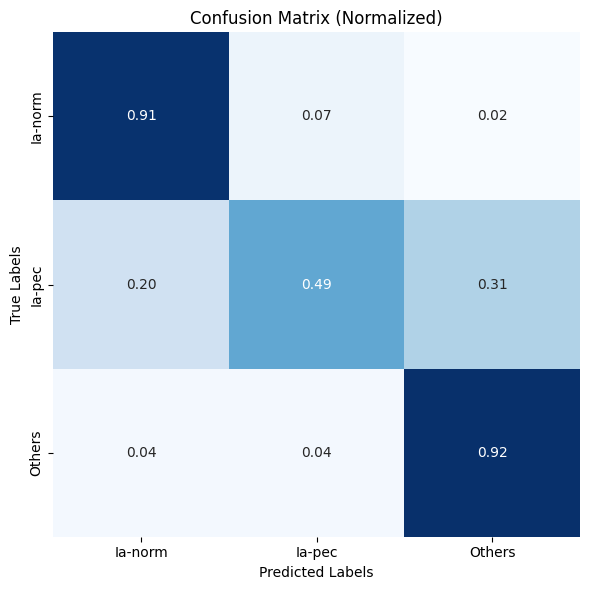

Loading augmented_images_v2.0_50x50...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.92it/s]


Epoch 1/200 | Train L/A/F1: 1.1021 0.3367 0.2684 | Val L/A/F1: 1.1188 0.2583 0.2308
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 2/200 | Train L/A/F1: 1.0785 0.4338 0.4052 | Val L/A/F1: 1.0728 0.5702 0.4962
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 3/200 | Train L/A/F1: 0.9060 0.6896 0.6781 | Val L/A/F1: 0.8130 0.7603 0.6856
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 4/200 | Train L/A/F1: 0.6000 0.8140 0.8094 | Val L/A/F1: 0.5795 0.7893 0.7325
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 5/200 | Train L/A/F1: 0.3897 0.8721 0.8707 | Val L/A/F1: 0.5083 0.7975 0.7302
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 6/200 | Train L/A/F1: 0.2852 0.9088 0.9084 | Val L/A/F1: 0.5694 0.7934 0.7329
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 7/200 | Train L/A/F1: 0.1896 0.9419 0.9417 | Val L/A/F1: 0.6567 0.7521 0.7393
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 8/200 | Train L/A/F1: 0.1456 0.9542 0.9541 | Val L/A/F1: 0.4104 0.8409 0.8112
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 9/200 | Train L/A/F1: 0.1016 0.9710 0.9709 | Val L/A/F1: 0.5362 0.8285 0.7813
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 10/200 | Train L/A/F1: 0.0747 0.9804 0.9804 | Val L/A/F1: 0.6890 0.7893 0.7559
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 11/200 | Train L/A/F1: 0.0553 0.9855 0.9855 | Val L/A/F1: 0.7385 0.8285 0.7833
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 12/200 | Train L/A/F1: 0.0504 0.9853 0.9853 | Val L/A/F1: 0.7653 0.8058 0.7576
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 13/200 | Train L/A/F1: 0.0430 0.9895 0.9895 | Val L/A/F1: 0.8322 0.8140 0.7675
Epoch 13 | LR = 1.00e-05


Epoch 14/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 14/200 | Train L/A/F1: 0.0323 0.9928 0.9928 | Val L/A/F1: 0.7335 0.8347 0.7995
Epoch 14 | LR = 1.00e-05


Epoch 15/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 15/200 | Train L/A/F1: 0.0230 0.9948 0.9947 | Val L/A/F1: 0.7433 0.8223 0.7883
Epoch 15 | LR = 1.00e-05
Early stopping after 15 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.9042    0.8930    0.8986       243
      Ia-pec     0.6239    0.7158    0.6667        95
      Others     0.9037    0.8356    0.8683       146

    accuracy                         0.8409       484
   macro avg     0.8106    0.8148    0.8112       484
weighted avg     0.8490    0.8409    0.8439       484



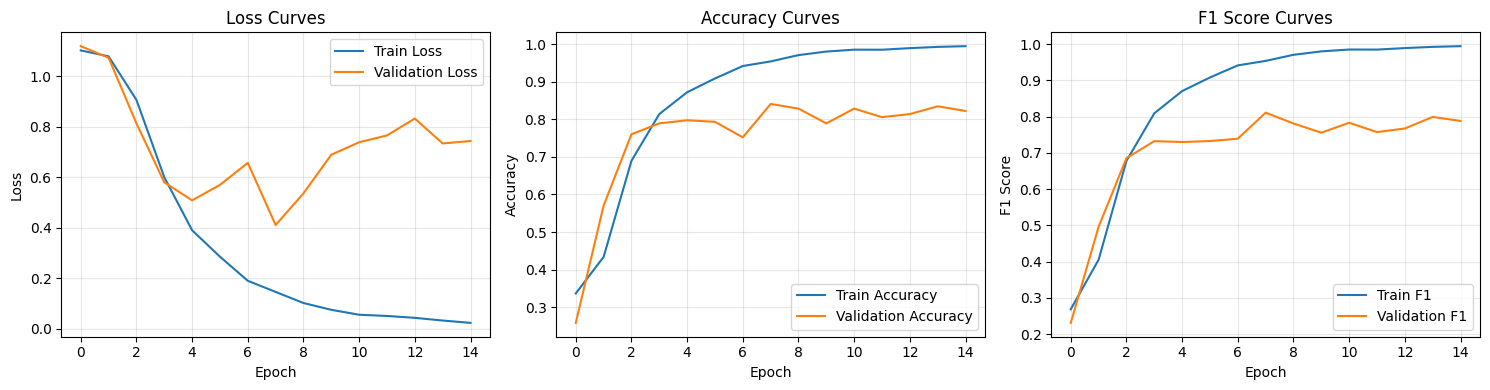

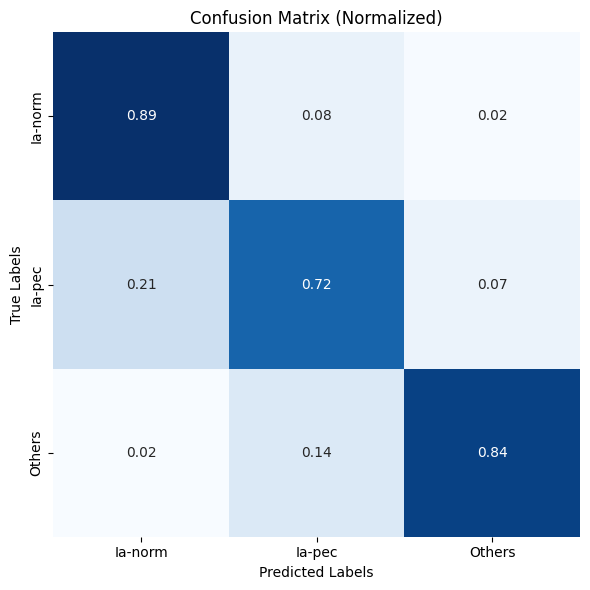

Loading augmented_images_v2.0_50x50...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 1/200 | Train L/A/F1: 1.1025 0.3384 0.2699 | Val L/A/F1: 1.1189 0.2397 0.2128
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 2/200 | Train L/A/F1: 1.0785 0.4280 0.4047 | Val L/A/F1: 1.0744 0.5826 0.5143
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 3/200 | Train L/A/F1: 0.9005 0.6962 0.6868 | Val L/A/F1: 0.8647 0.7045 0.6280
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 4/200 | Train L/A/F1: 0.6012 0.8089 0.8040 | Val L/A/F1: 0.6279 0.7583 0.6804
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 5/200 | Train L/A/F1: 0.3865 0.8723 0.8709 | Val L/A/F1: 0.6071 0.7459 0.6722
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 6/200 | Train L/A/F1: 0.2658 0.9102 0.9096 | Val L/A/F1: 0.5437 0.7893 0.7539
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 7/200 | Train L/A/F1: 0.1869 0.9409 0.9406 | Val L/A/F1: 0.5176 0.8140 0.7731
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 8/200 | Train L/A/F1: 0.1420 0.9580 0.9579 | Val L/A/F1: 0.5949 0.7872 0.7510
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 9/200 | Train L/A/F1: 0.1015 0.9692 0.9692 | Val L/A/F1: 0.5704 0.8264 0.7921
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 10/200 | Train L/A/F1: 0.0738 0.9822 0.9821 | Val L/A/F1: 0.5639 0.8285 0.8039
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 11/200 | Train L/A/F1: 0.0618 0.9825 0.9825 | Val L/A/F1: 0.8225 0.7748 0.7571
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 12/200 | Train L/A/F1: 0.0530 0.9871 0.9870 | Val L/A/F1: 0.6267 0.8285 0.7992
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 13/200 | Train L/A/F1: 0.0323 0.9935 0.9935 | Val L/A/F1: 0.7008 0.8202 0.7968
Epoch 13 | LR = 1.00e-05


Epoch 14/200: 100%|██████████| 179/179 [00:16<00:00, 11.00it/s]


Epoch 14/200 | Train L/A/F1: 0.0416 0.9900 0.9900 | Val L/A/F1: 0.7711 0.8017 0.7529
Epoch 14 | LR = 1.00e-05
Early stopping after 14 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.9087    0.8189    0.8615       243
      Ia-pec     0.5982    0.7053    0.6473        95
      Others     0.8824    0.9247    0.9030       146

    accuracy                         0.8285       484
   macro avg     0.7964    0.8163    0.8039       484
weighted avg     0.8398    0.8285    0.8320       484



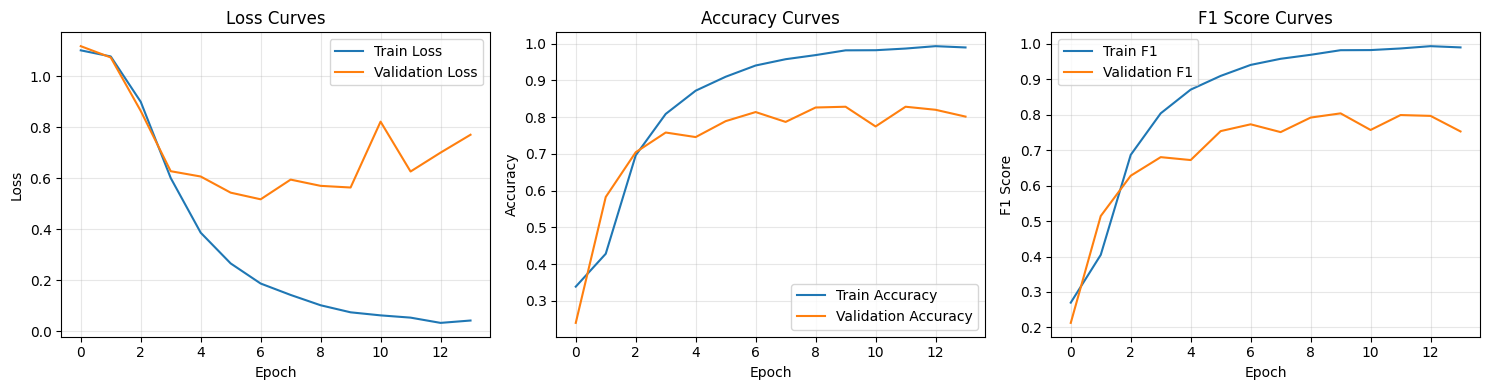

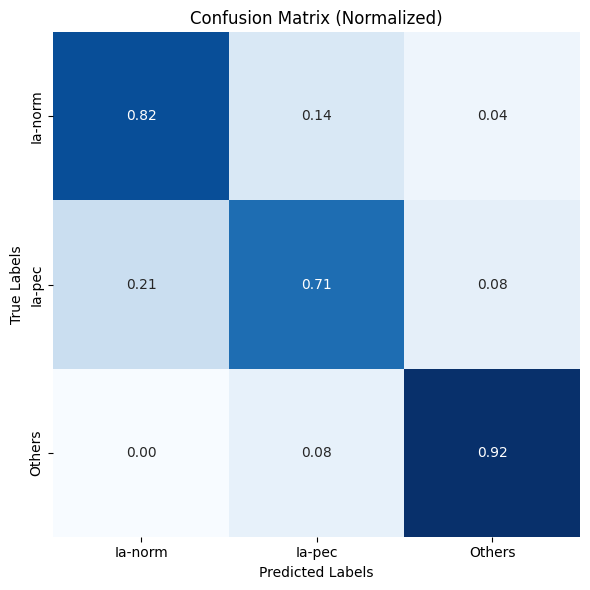

Loading augmented_images_v2.0_50x50_n...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.91it/s]


Epoch 1/200 | Train L/A/F1: 1.0999 0.3155 0.2273 | Val L/A/F1: 1.1120 0.3017 0.1545
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 2/200 | Train L/A/F1: 1.0734 0.4423 0.4259 | Val L/A/F1: 1.0588 0.5702 0.4245
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 3/200 | Train L/A/F1: 0.9042 0.6779 0.6656 | Val L/A/F1: 0.8824 0.6467 0.5253
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 4/200 | Train L/A/F1: 0.6334 0.7930 0.7859 | Val L/A/F1: 0.6836 0.7438 0.6386
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 5/200 | Train L/A/F1: 0.4398 0.8521 0.8500 | Val L/A/F1: 0.5533 0.8161 0.7523
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 6/200 | Train L/A/F1: 0.3272 0.8856 0.8844 | Val L/A/F1: 0.5277 0.8017 0.7330
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 7/200 | Train L/A/F1: 0.2601 0.9111 0.9105 | Val L/A/F1: 0.5258 0.8058 0.7520
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 8/200 | Train L/A/F1: 0.2036 0.9332 0.9328 | Val L/A/F1: 0.5071 0.8120 0.7687
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 9/200 | Train L/A/F1: 0.1654 0.9452 0.9451 | Val L/A/F1: 0.6172 0.7810 0.7468
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 10/200 | Train L/A/F1: 0.1412 0.9554 0.9553 | Val L/A/F1: 0.6181 0.8017 0.7673
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 11/200 | Train L/A/F1: 0.0963 0.9732 0.9732 | Val L/A/F1: 0.6375 0.8161 0.7615
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.99it/s]


Epoch 12/200 | Train L/A/F1: 0.0903 0.9732 0.9732 | Val L/A/F1: 0.6676 0.7893 0.7528
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 13/200 | Train L/A/F1: 0.0672 0.9804 0.9804 | Val L/A/F1: 0.7890 0.7975 0.7663
Epoch 13 | LR = 1.00e-05


Epoch 14/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 14/200 | Train L/A/F1: 0.0511 0.9855 0.9855 | Val L/A/F1: 0.6712 0.8140 0.7819
Epoch 14 | LR = 1.00e-05


Epoch 15/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 15/200 | Train L/A/F1: 0.0560 0.9830 0.9830 | Val L/A/F1: 0.7509 0.7913 0.7591
Epoch 15 | LR = 1.00e-05
Early stopping after 15 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.8669    0.8848    0.8758       243
      Ia-pec     0.5872    0.6737    0.6275        95
      Others     0.9055    0.7877    0.8425       146

    accuracy                         0.8140       484
   macro avg     0.7865    0.7820    0.7819       484
weighted avg     0.8237    0.8140    0.8170       484



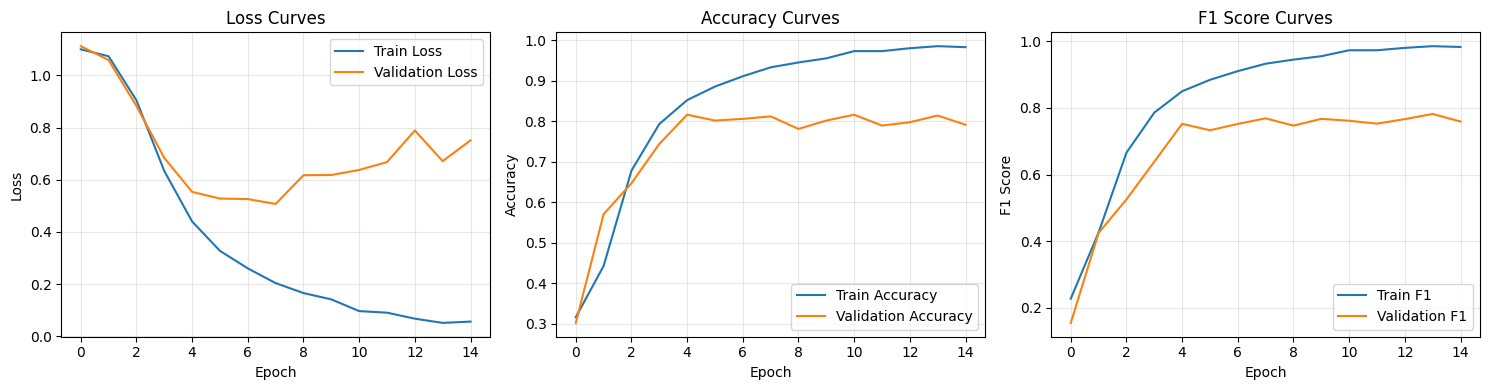

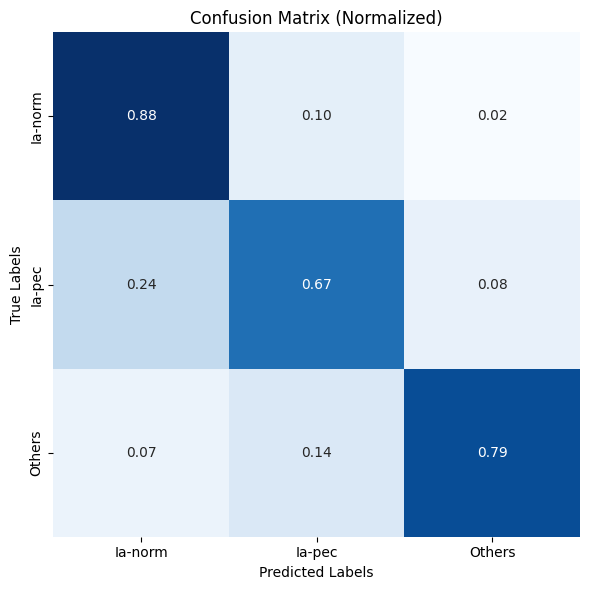

Loading augmented_images_v2.0_50x50_n...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.90it/s]


Epoch 1/200 | Train L/A/F1: 1.0998 0.3181 0.2302 | Val L/A/F1: 1.1113 0.2975 0.1529
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 2/200 | Train L/A/F1: 1.0733 0.4397 0.4226 | Val L/A/F1: 1.0516 0.5950 0.4545
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.99it/s]


Epoch 3/200 | Train L/A/F1: 0.9041 0.6798 0.6676 | Val L/A/F1: 0.8063 0.7293 0.6205
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 4/200 | Train L/A/F1: 0.6172 0.7965 0.7901 | Val L/A/F1: 0.7202 0.7045 0.6311
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 5/200 | Train L/A/F1: 0.4354 0.8492 0.8470 | Val L/A/F1: 0.5475 0.7789 0.6810
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 6/200 | Train L/A/F1: 0.3342 0.8835 0.8824 | Val L/A/F1: 0.5056 0.8058 0.7222
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 7/200 | Train L/A/F1: 0.2510 0.9155 0.9148 | Val L/A/F1: 0.5351 0.8037 0.7552
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 8/200 | Train L/A/F1: 0.2205 0.9253 0.9249 | Val L/A/F1: 0.5170 0.8079 0.7433
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 9/200 | Train L/A/F1: 0.1707 0.9466 0.9465 | Val L/A/F1: 0.5710 0.8079 0.7602
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 10/200 | Train L/A/F1: 0.1461 0.9556 0.9555 | Val L/A/F1: 0.4877 0.8409 0.8015
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 11/200 | Train L/A/F1: 0.1055 0.9689 0.9688 | Val L/A/F1: 0.6152 0.8326 0.8015
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.98it/s]


Epoch 12/200 | Train L/A/F1: 0.0773 0.9802 0.9802 | Val L/A/F1: 0.6673 0.8079 0.7788
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 13/200 | Train L/A/F1: 0.0794 0.9788 0.9788 | Val L/A/F1: 0.5353 0.8554 0.8270
Epoch 13 | LR = 1.00e-05


Epoch 14/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 14/200 | Train L/A/F1: 0.0776 0.9783 0.9783 | Val L/A/F1: 0.6628 0.8161 0.7549
Epoch 14 | LR = 1.00e-05


Epoch 15/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 15/200 | Train L/A/F1: 0.0615 0.9822 0.9821 | Val L/A/F1: 0.5601 0.8388 0.8004
Epoch 15 | LR = 1.00e-05


Epoch 16/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 16/200 | Train L/A/F1: 0.0338 0.9925 0.9925 | Val L/A/F1: 0.6110 0.8430 0.8163
Epoch 16 | LR = 1.00e-05


Epoch 17/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 17/200 | Train L/A/F1: 0.0632 0.9797 0.9797 | Val L/A/F1: 0.5977 0.8388 0.8118
Epoch 17 | LR = 1.00e-05
Early stopping after 17 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.9020    0.9095    0.9057       243
      Ia-pec     0.6869    0.7158    0.7010        95
      Others     0.8929    0.8562    0.8741       146

    accuracy                         0.8554       484
   macro avg     0.8273    0.8271    0.8270       484
weighted avg     0.8570    0.8554    0.8560       484



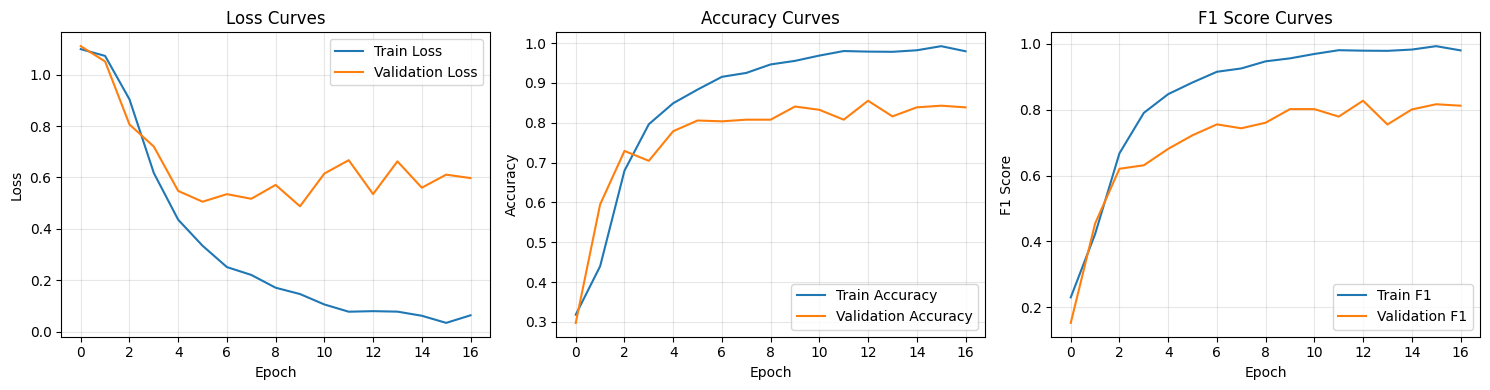

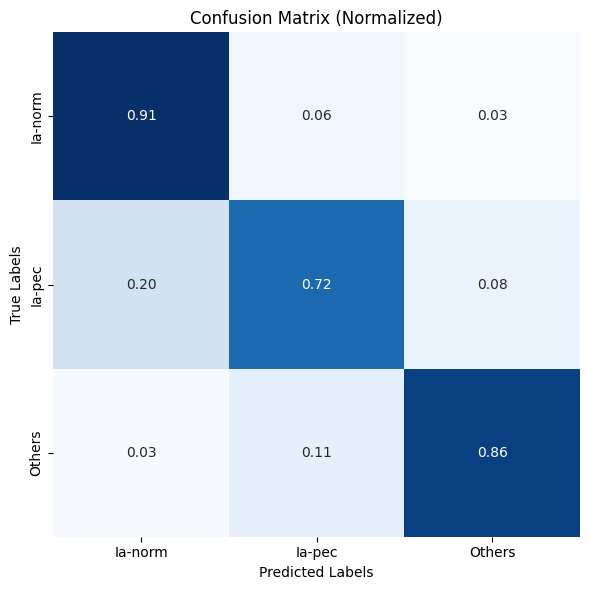

Loading augmented_images_v2.0_50x50_n...
Using constant scheduler with warmup..


Epoch 1/200: 100%|██████████| 179/179 [00:16<00:00, 10.90it/s]


Epoch 1/200 | Train L/A/F1: 1.0999 0.3155 0.2261 | Val L/A/F1: 1.1120 0.3017 0.1547
Epoch 1 | LR = 2.50e-06


Epoch 2/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 2/200 | Train L/A/F1: 1.0736 0.4387 0.4233 | Val L/A/F1: 1.0627 0.5806 0.4484
Epoch 2 | LR = 5.00e-06


Epoch 3/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 3/200 | Train L/A/F1: 0.9013 0.6835 0.6703 | Val L/A/F1: 0.8855 0.6488 0.5583
Epoch 3 | LR = 7.50e-06


Epoch 4/200: 100%|██████████| 179/179 [00:16<00:00, 10.94it/s]


Epoch 4/200 | Train L/A/F1: 0.6222 0.7955 0.7894 | Val L/A/F1: 0.7077 0.7025 0.6056
Epoch 4 | LR = 1.00e-05


Epoch 5/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 5/200 | Train L/A/F1: 0.4413 0.8553 0.8534 | Val L/A/F1: 0.6451 0.7417 0.6578
Epoch 5 | LR = 1.00e-05


Epoch 6/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 6/200 | Train L/A/F1: 0.3429 0.8861 0.8852 | Val L/A/F1: 0.6091 0.7562 0.6825
Epoch 6 | LR = 1.00e-05


Epoch 7/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 7/200 | Train L/A/F1: 0.2531 0.9157 0.9151 | Val L/A/F1: 0.6311 0.7541 0.6966
Epoch 7 | LR = 1.00e-05


Epoch 8/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 8/200 | Train L/A/F1: 0.2205 0.9225 0.9221 | Val L/A/F1: 0.6198 0.7872 0.6894
Epoch 8 | LR = 1.00e-05


Epoch 9/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 9/200 | Train L/A/F1: 0.1771 0.9419 0.9417 | Val L/A/F1: 0.5963 0.7975 0.6991
Epoch 9 | LR = 1.00e-05


Epoch 10/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 10/200 | Train L/A/F1: 0.1395 0.9550 0.9549 | Val L/A/F1: 0.6903 0.7603 0.7095
Epoch 10 | LR = 1.00e-05


Epoch 11/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 11/200 | Train L/A/F1: 0.1028 0.9676 0.9676 | Val L/A/F1: 0.8021 0.7500 0.7163
Epoch 11 | LR = 1.00e-05


Epoch 12/200: 100%|██████████| 179/179 [00:16<00:00, 10.96it/s]


Epoch 12/200 | Train L/A/F1: 0.0872 0.9746 0.9746 | Val L/A/F1: 0.6694 0.7624 0.7136
Epoch 12 | LR = 1.00e-05


Epoch 13/200: 100%|██████████| 179/179 [00:16<00:00, 10.97it/s]


Epoch 13/200 | Train L/A/F1: 0.0771 0.9769 0.9769 | Val L/A/F1: 0.7386 0.7810 0.7230
Epoch 13 | LR = 1.00e-05


Epoch 14/200: 100%|██████████| 179/179 [00:16<00:00, 10.99it/s]


Epoch 14/200 | Train L/A/F1: 0.0471 0.9892 0.9891 | Val L/A/F1: 0.7665 0.7913 0.7280
Epoch 14 | LR = 1.00e-05


Epoch 15/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 15/200 | Train L/A/F1: 0.0429 0.9878 0.9877 | Val L/A/F1: 1.0272 0.7562 0.7262
Epoch 15 | LR = 1.00e-05


Epoch 16/200: 100%|██████████| 179/179 [00:16<00:00, 10.95it/s]


Epoch 16/200 | Train L/A/F1: 0.0550 0.9837 0.9837 | Val L/A/F1: 0.7797 0.7789 0.7309
Epoch 16 | LR = 1.00e-05
Early stopping after 16 epochs.

=== Classification Report ===
              precision    recall  f1-score   support

     Ia-norm     0.8368    0.8230    0.8299       243
      Ia-pec     0.5172    0.4737    0.4945        95
      Others     0.8354    0.9041    0.8684       146

    accuracy                         0.7789       484
   macro avg     0.7298    0.7336    0.7309       484
weighted avg     0.7737    0.7789    0.7757       484



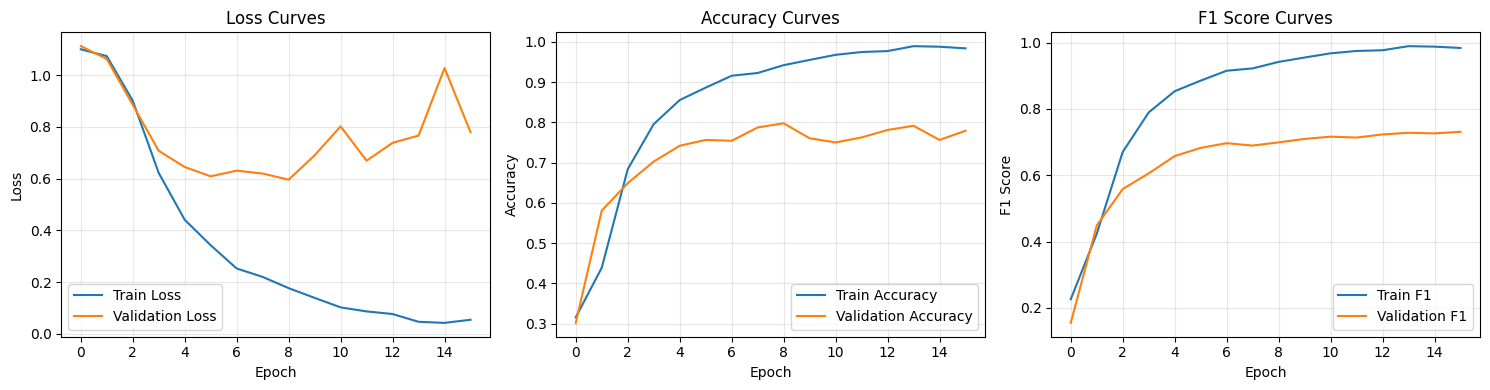

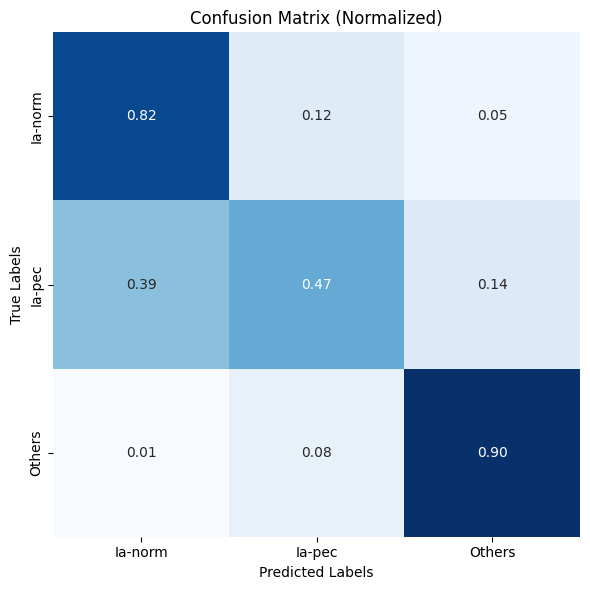

In [31]:
pt_model_name = pt_model_names['DINOv3']

hp = {
    'batch_size': 32,
    'lr': 1e-5,
    'wd': 1e-4,
    'dropout': 0.3,
    'epochs': 200,
    'patience': 7,
    'freeze': False,
    'head_n': 3,
    'scheduler': 'constant',
}

for dataset_name in dataset_versions:
  for splits_n in [1,2,3]:
    save_dir = f"Phase2/DINOv3/{dataset_name.split('augmented_images_')[1]}/split{splits_n}"
    run(dataset_name, hp, pt_model_name, splits_n, save_dir)

In [16]:
# import itertools

# config = {
#     "pt_model_name": ["ViT32"],
#     "freeze": [True, False, 4],
#     "split": [0, 1, 2, 3]
# }

# keys = config.keys()
# values = config.values()

# for combo in itertools.product(*values):
#     params = dict(zip(keys, combo))
#     print(params)